<a href="https://colab.research.google.com/github/raktim711/AIMS-project---Anomaly-Detection/blob/main/exploratory_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import h5py
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import umap.umap_ as umap

In [2]:
# sns.set_theme(style="whitegrid", context="notebook", palette="deep")
plt.style.use('ggplot')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the Data

In [6]:
def combine_data(datasets, tags_to_combine, new_tag, delete_old_tags=True):
    """
    Combines subdicts of the 'datasets' dict.

    Inputs:
        datasets: dict that maps {dataset_tag : dataset_dict}
        tags_to_combine: list if strings [dataset_tag1, ..., dataset_tagN] of the tags to be combined
        new_tag: the name of the new tag of the combined subdict

    Returns:
        datasets: same datasets dict as input, but with the specified tags combined.
    """

    # initialize empty lists for new tag
    datasets[new_tag] = {key: [] for key in datasets[tags_to_combine[0]].keys()}

    # Loop through old tags and append np arrays to lists
    for tag in tags_to_combine:
        for key, value in datasets[tag].items():
            datasets[new_tag][key].append(value)

    # Concatenate lists into single np array
    for key, value in datasets[new_tag].items():
        datasets[new_tag][key] = np.concatenate(value, axis=0)

    # Delete old tags
    if delete_old_tags:
        for tag in tags_to_combine:
            del datasets[tag]

    # Make sure everything is an np array
    for tag, data_dict in datasets.items():
        for key, value in data_dict.items():
            data_dict[key] = np.array(value)

    return datasets

In [7]:
# Load the data

datasets = {} # dictionary of dictionaries, each dictionary is a dataset

# base_dir = '/kaggle/input/addata/ADdata'
base_dir = '/content/drive/MyDrive/Colab Notebooks/ADdata'

# loop over all the files in the base directory
for tag in os.listdir(base_dir):
    file_path = os.path.join(base_dir, tag)

    datasets[tag] = {}

    # load the data from the file
    with h5py.File(file_path, 'r') as hf:
        for key in hf.keys():
            datasets[tag][key] = hf[key][:]

# Print the shape of the data
for tag, data_dict in datasets.items():
    print(f'{tag}:')
    for key, value in data_dict.items():
        print(f'  {key}: {value.shape}')

EB25_500306.h5:
  HLTAD_scores: (1017586,)
  HLT_data: (1017586, 48)
  HLT_el_IDs: (1017586, 3)
  HLT_jet_E: (1017586, 6)
  HLT_z: (1017586, 4)
  L1AD_scores: (1017586,)
  L1_data: (1017586, 44)
  LBs: (1017586,)
  avg_ints: (1017586,)
  bcid: (1017586,)
  event_numbers: (1017586,)
  mus: (1017586,)
  online_AD_scores: (1017586,)
  passHLTAD_online: (1017586,)
  passL1ADL_online: (1017586,)
  passL1ADT_online: (1017586,)
  pass_HLTAD: (1017586,)
  pass_HLT_unprescaled: (1017586,)
  pass_L1AD: (1017586,)
  pass_L1_unprescaled: (1017586,)
  pass_single_jet_trigger: (1017586,)
  run_numbers: (1017586,)
  weights: (1017586,)
MC_HAHMggf_470000.h5:
  HLTAD_scores: (100000,)
  HLT_data: (100000, 48)
  HLT_el_IDs: (100000, 3)
  HLT_jet_E: (100000, 6)
  HLT_z: (100000, 4)
  L1AD_scores: (100000,)
  L1_data: (100000, 44)
  LBs: (100000,)
  avg_ints: (100000,)
  bcid: (100000,)
  event_numbers: (100000,)
  mus: (100000,)
  online_AD_scores: (100000,)
  passHLTAD_online: (100000,)
  passL1ADL_onli

In [8]:
# Remove EB24 data
for tag in [key for key in datasets.keys()]:
    if tag.startswith('EB24'):
        del datasets[tag]

# Rename EB25 to EB_test
datasets['EB_test'] = datasets.pop('EB25_500306.h5')

In [9]:
# Change pass_HLT_unprescaled to boolean and add weights for MC
for tag, data_dict in datasets.items():
    data_dict['passHLT'] = data_dict['pass_HLT_unprescaled']==1
    del data_dict['pass_HLT_unprescaled']

    data_dict['passL1'] = data_dict['pass_L1_unprescaled']==1
    del data_dict['pass_L1_unprescaled']

    if tag.startswith('MC'):
        data_dict['weights'] = np.ones(len(data_dict['run_numbers']))

Except for ```EB_test```, all the other classes have been weighted 1.0



In [10]:
# Rename the MC tags for clarity

original_tags = [tag for tag in datasets.keys()]

for tag in original_tags:
    if tag.startswith('MC'):
        new_tag = tag.split('MC_')[1]
        new_tag = new_tag.split('_470000')[0]

        if new_tag == 'hh':
            new_tag = 'hh_bbbb_vbf_novhh_5fs_l1cvv1cv1'

        datasets[new_tag] = datasets.pop(tag)

for tag, data_dict in datasets.items():
    print(f'{tag}:')
    for key, value in data_dict.items():
        print(f'  {key}: {value.shape}')

EB_test:
  HLTAD_scores: (1017586,)
  HLT_data: (1017586, 48)
  HLT_el_IDs: (1017586, 3)
  HLT_jet_E: (1017586, 6)
  HLT_z: (1017586, 4)
  L1AD_scores: (1017586,)
  L1_data: (1017586, 44)
  LBs: (1017586,)
  avg_ints: (1017586,)
  bcid: (1017586,)
  event_numbers: (1017586,)
  mus: (1017586,)
  online_AD_scores: (1017586,)
  passHLTAD_online: (1017586,)
  passL1ADL_online: (1017586,)
  passL1ADT_online: (1017586,)
  pass_HLTAD: (1017586,)
  pass_L1AD: (1017586,)
  pass_single_jet_trigger: (1017586,)
  run_numbers: (1017586,)
  weights: (1017586,)
  passHLT: (1017586,)
  passL1: (1017586,)
HAHMggf:
  HLTAD_scores: (100000,)
  HLT_data: (100000, 48)
  HLT_el_IDs: (100000, 3)
  HLT_jet_E: (100000, 6)
  HLT_z: (100000, 4)
  L1AD_scores: (100000,)
  L1_data: (100000, 44)
  LBs: (100000,)
  avg_ints: (100000,)
  bcid: (100000,)
  event_numbers: (100000,)
  mus: (100000,)
  online_AD_scores: (100000,)
  passHLTAD_online: (100000,)
  passL1ADL_online: (100000,)
  passL1ADT_online: (100000,)
  

In [11]:
HLT_data_tags = [tag for tag in datasets.keys() if not tag.startswith('MC')]

In [12]:
print(HLT_data_tags)

['EB_test', 'HAHMggf', 'HNLeemu', 'HtoSUEP', 'VBF_H125_a55a55_4b_ctau1_filtered', 'Znunu', 'ggF_H125_a16a16_4b_ctau10_filtered', 'hh_bbbb_vbf_novhh_5fs_l1cvv1cv1']


In [13]:
# Define column names for HLT_data
columns = ['j0pt', 'j0eta', 'j0phi', 'j1pt', 'j1eta', 'j1phi',
           'j2pt', 'j2eta', 'j2phi', 'j3pt', 'j3eta', 'j3phi',
           'j4pt', 'j4eta', 'j4phi', 'j5pt', 'j5eta', 'j5phi',
           'e0pt', 'e0eta', 'e0phi', 'e1pt', 'e1eta', 'e1phi',
           'e2pt', 'e2eta', 'e2phi', 'mu0pt', 'mu0eta', 'mu0phi',
           'mu1pt', 'mu1eta', 'mu1phi', 'mu2pt', 'mu2eta', 'mu2phi',
           'ph0pt', 'ph0eta', 'ph0phi', 'ph1pt', 'ph1eta', 'ph1phi',
           'ph2pt', 'ph2eta', 'ph2phi', 'METpt', 'METeta', 'METphi']

In [14]:
combined_hlt_df = pd.concat([
    pd.DataFrame(datasets[tag]['HLT_data'], columns=columns)
      .assign(weight=np.asarray(datasets[tag]['weights']).reshape(-1), target=tag)
    for tag in datasets
], ignore_index=True)
combined_hlt_df.head()

,j0pt,j0eta,j0phi,j1pt,j1eta,j1phi,j2pt,j2eta,j2phi,j3pt,...,ph1eta,ph1phi,ph2pt,ph2eta,ph2phi,METpt,METeta,METphi,weight,target
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.009135,0.0,-1.915390,5.0,EB_test
1,23.893738,-0.032734,1.230678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.742011,0.0,-1.910914,5.0,EB_test
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,12.0,EB_test
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.936713,0.0,-0.541381,12.0,EB_test
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,5.0,EB_test


## Exploratory Data Visualisation

How many events are assigned a METpt?

Total number of events with non-zero METpt: 1042248

Number of events with non-zero METpt for each target:
target
EB_test                               624643
VBF_H125_a55a55_4b_ctau1_filtered      98561
HtoSUEP                                88288
HNLeemu                                82614
HAHMggf                                78684
hh_bbbb_vbf_novhh_5fs_l1cvv1cv1        49615
ggF_H125_a16a16_4b_ctau10_filtered     10000
Znunu                                   9843
Name: count, dtype: int64


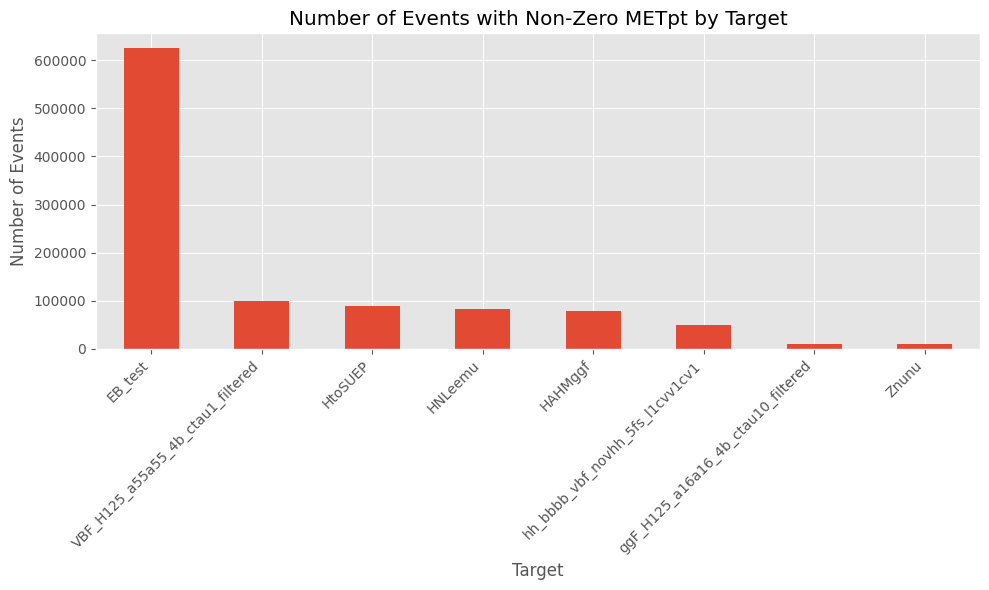

In [15]:
# Count total number of events with non-zero METpt
total_non_zero_METpt = (combined_hlt_df['METpt'] != 0).sum()

# Count number of events with non-zero METpt for each target
non_zero_METpt_by_target = combined_hlt_df[combined_hlt_df['METpt'] != 0]['target'].value_counts()

print(f"Total number of events with non-zero METpt: {total_non_zero_METpt}")
print("\nNumber of events with non-zero METpt for each target:")
print(non_zero_METpt_by_target)

# Plot a bar graph of the counts
plt.figure(figsize=(10, 6))
non_zero_METpt_by_target.plot(kind='bar')
plt.title('Number of Events with Non-Zero METpt by Target')
plt.xlabel('Target')
plt.ylabel('Number of Events')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

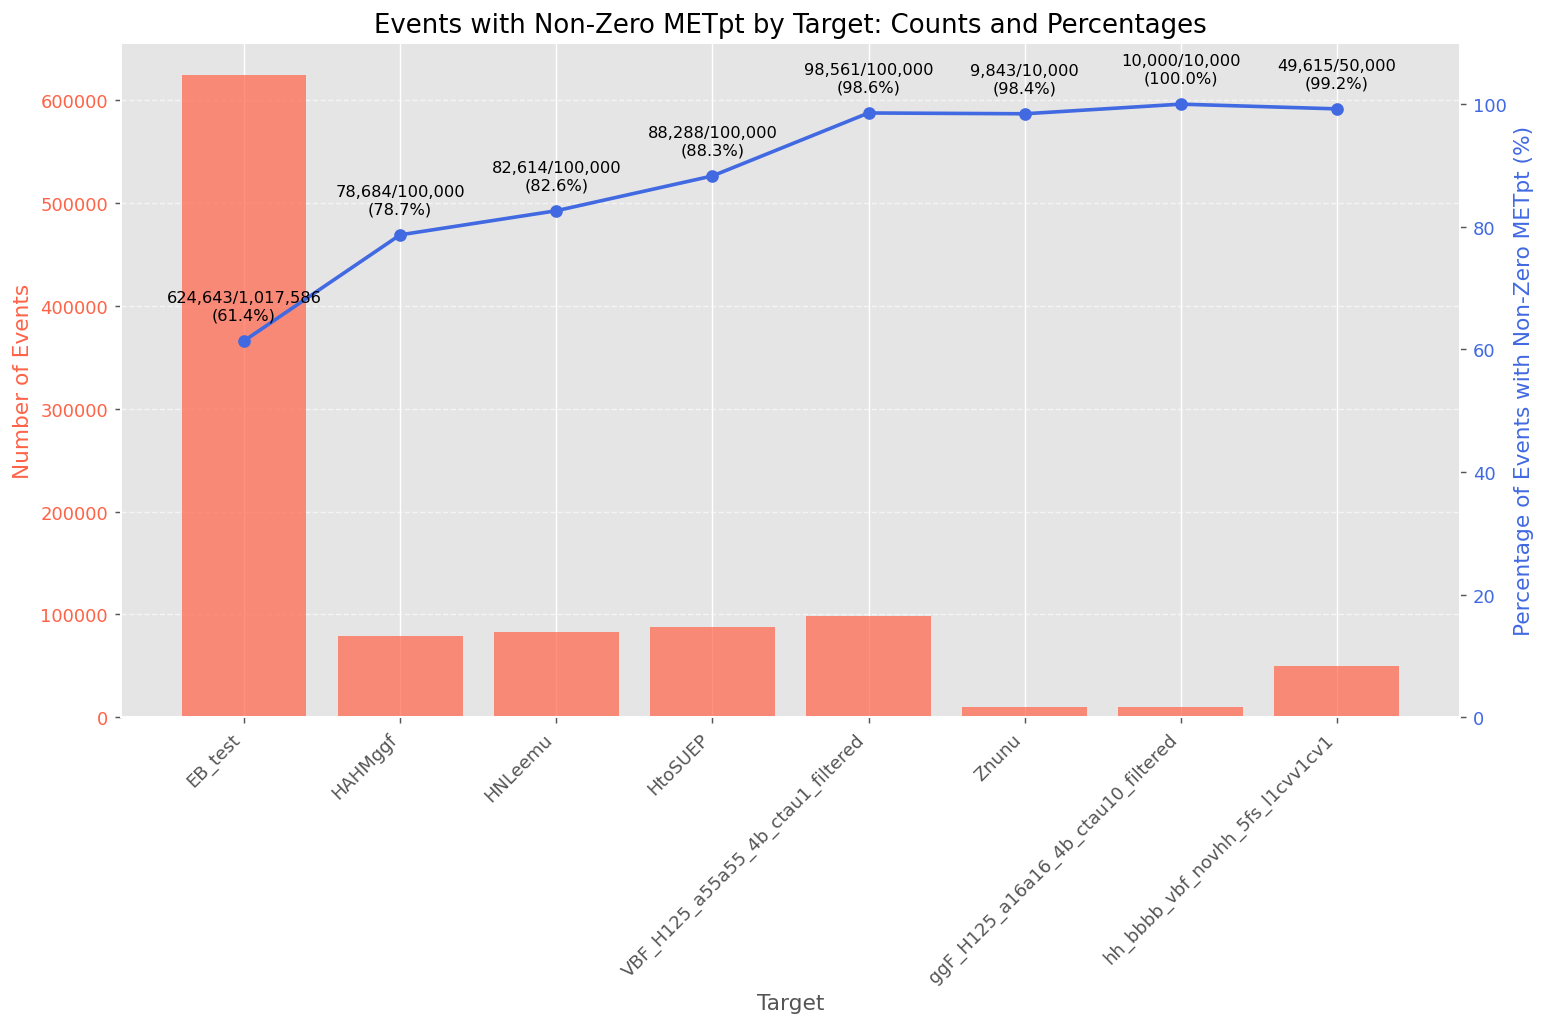

In [16]:
# Count total number of events per target
total_events_by_target = combined_hlt_df['target'].value_counts().sort_index()

# Count number of events with non-zero METpt per target
non_zero_METpt_by_target = combined_hlt_df[combined_hlt_df['METpt'] != 0]['target'].value_counts().sort_index()

# Compute percentage of non-zero METpt events per target
percent_non_zero_METpt = (non_zero_METpt_by_target / total_events_by_target * 100)

# --- Combined plot ---
fig, ax1 = plt.subplots(figsize=(12, 8),dpi=130)

# Left y-axis: counts
bars = ax1.bar(
    non_zero_METpt_by_target.index,
    non_zero_METpt_by_target.values,
    color='tomato',
    alpha=0.7,
    label='Number of Events'
)
ax1.set_xlabel('Target')
ax1.set_ylabel('Number of Events', color='tomato')
ax1.tick_params(axis='y', labelcolor='tomato')

# Rotate x-axis labels
plt.xticks(ticks=range(len(non_zero_METpt_by_target.index)),
           labels=non_zero_METpt_by_target.index,
           rotation=45, ha='right')

# Enable grid only on ax1
ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.6)

# Right y-axis: percentage
ax2 = ax1.twinx()
ax2.plot(
    percent_non_zero_METpt.index,
    percent_non_zero_METpt.values,
    color='royalblue',
    marker='o',
    linewidth=2,
    label='Percentage of Events'
)
ax2.set_ylabel('Percentage of Events with Non-Zero METpt (%)', color='royalblue')
ax2.tick_params(axis='y', labelcolor='royalblue')
ax2.set_ylim(0, 110)
ax2.grid(False)

# Annotate each point with both percentage and counts
for i, (count, total, pct) in enumerate(zip(
    non_zero_METpt_by_target.values,
    total_events_by_target.values,
    percent_non_zero_METpt.values
)):
    ax2.text(
        i, pct + 3,
        f'{count:,}/{total:,}\n({pct:.1f}%)',  # formatted nicely with commas
        ha='center', va='bottom',
        fontsize=9, color='black'
    )

# Title and layout
plt.title('Events with Non-Zero METpt by Target: Counts and Percentages')
fig.tight_layout()
plt.show()


In [17]:
# Define the target name you want to filter by
target_name = 'EB_test'
filtered_df = combined_hlt_df[combined_hlt_df['target'] == target_name].drop(['target', 'weight'], axis=1)

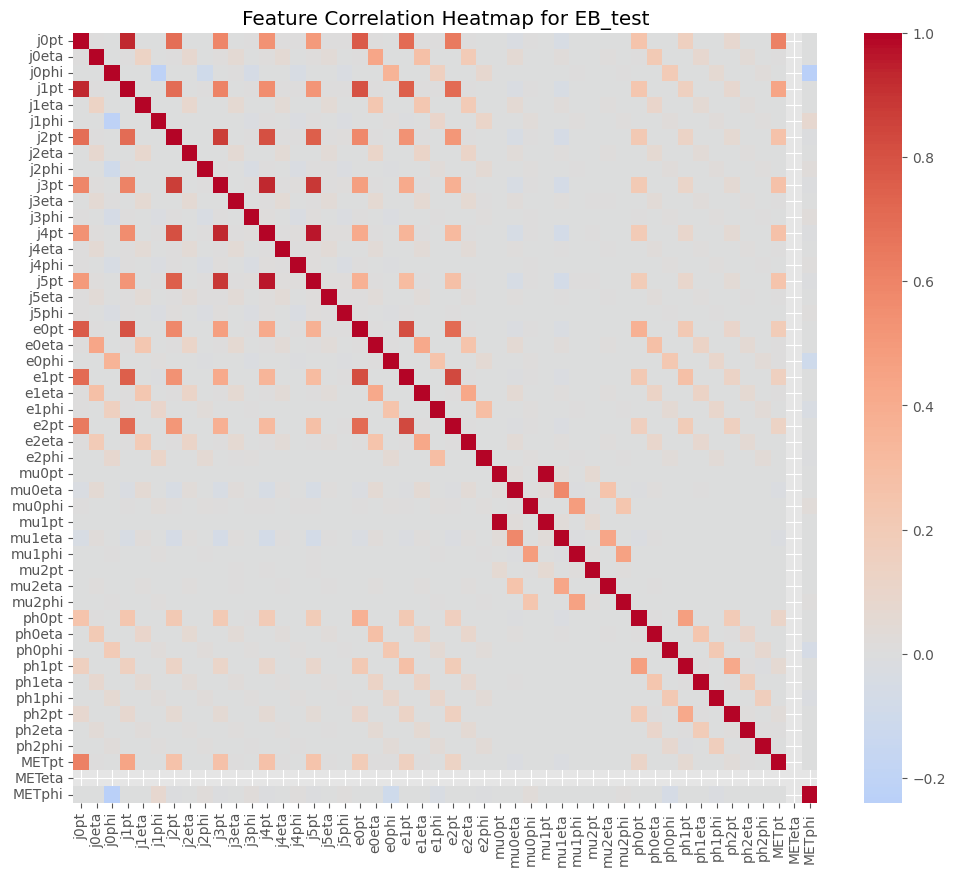

In [18]:
# Filter the DataFrame for the specified target, drop the target column, and calculate correlation
corr = filtered_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title(f'Feature Correlation Heatmap for {target_name}')
plt.show()

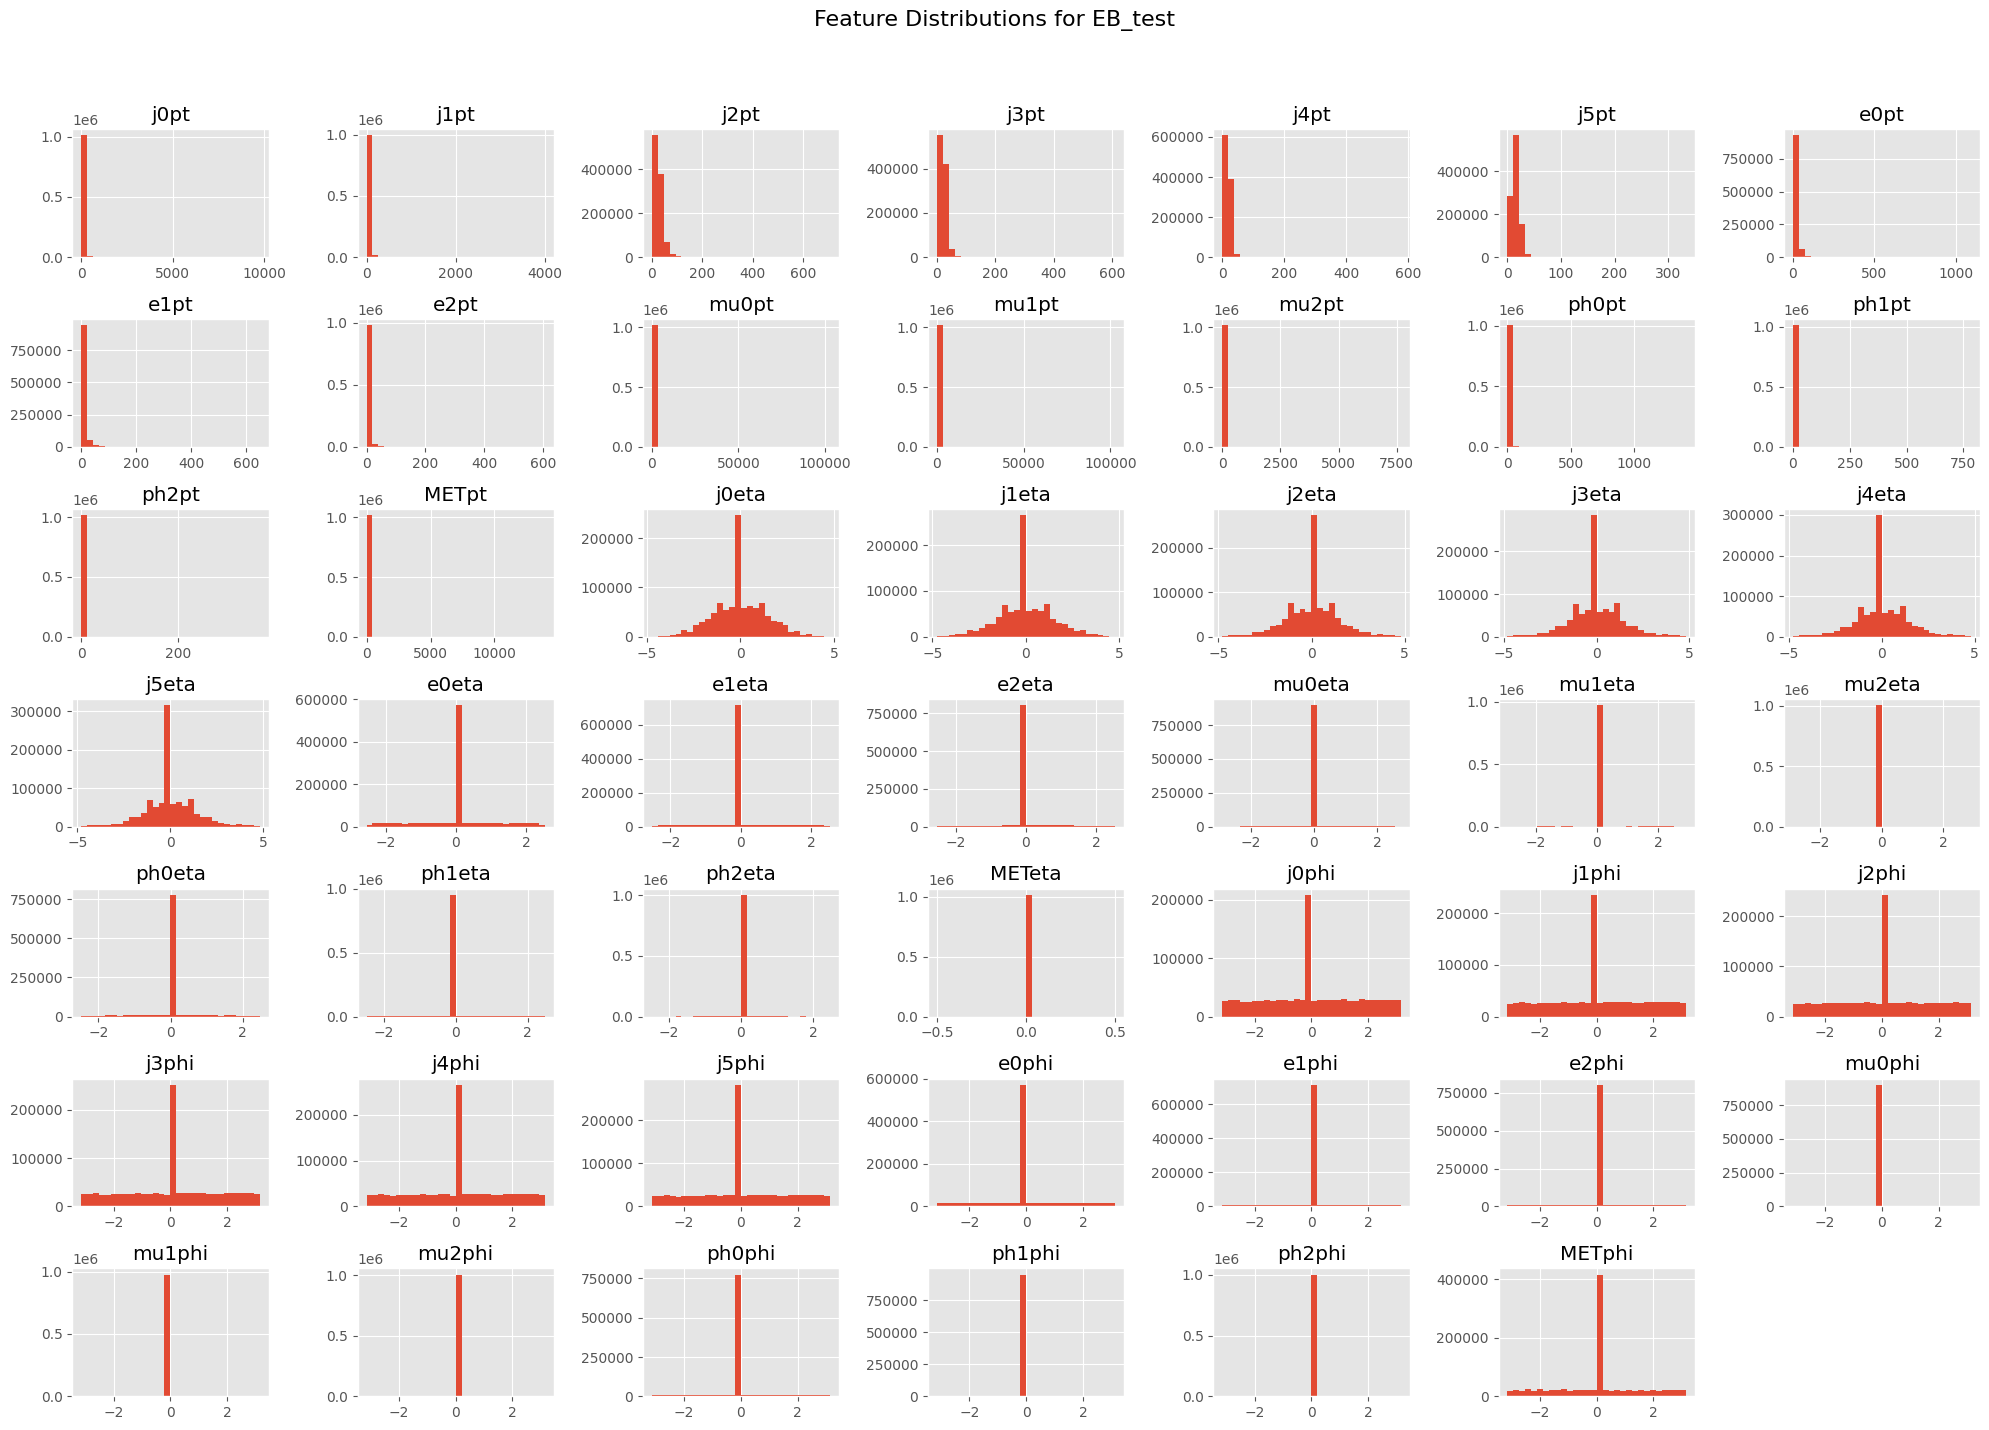

In [19]:
# Plot histograms directly from the filtered and dropped DataFrame
# Quick and Simple plot
# combined_hlt_df[combined_hlt_df['target'] == target_name].drop('target', axis=1).hist(figsize=(20,15), bins=30)

# plt.suptitle(f'Feature Distributions for {target_name}')
# plt.tight_layout()
# plt.show()


# Filter data for the selected target
df_target = filtered_df

# Define feature groups based on name patterns
pt_cols = [c for c in df_target.columns if 'pt' in c]
eta_cols = [c for c in df_target.columns if 'eta' in c]
phi_cols = [c for c in df_target.columns if 'phi' in c]
# met_cols = [c for c in df_target.columns if 'MET' in c]
other_cols = ['weight'] if 'weight' in df_target.columns else []

# Combine in desired order
ordered_cols = pt_cols + eta_cols + phi_cols + other_cols

# Plot histograms grouped by type
df_target[ordered_cols].hist(
    figsize=(20, 15),
    bins=30,
)

plt.suptitle(f'Feature Distributions for {target_name}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Total number of events with weight > 400000: 225382


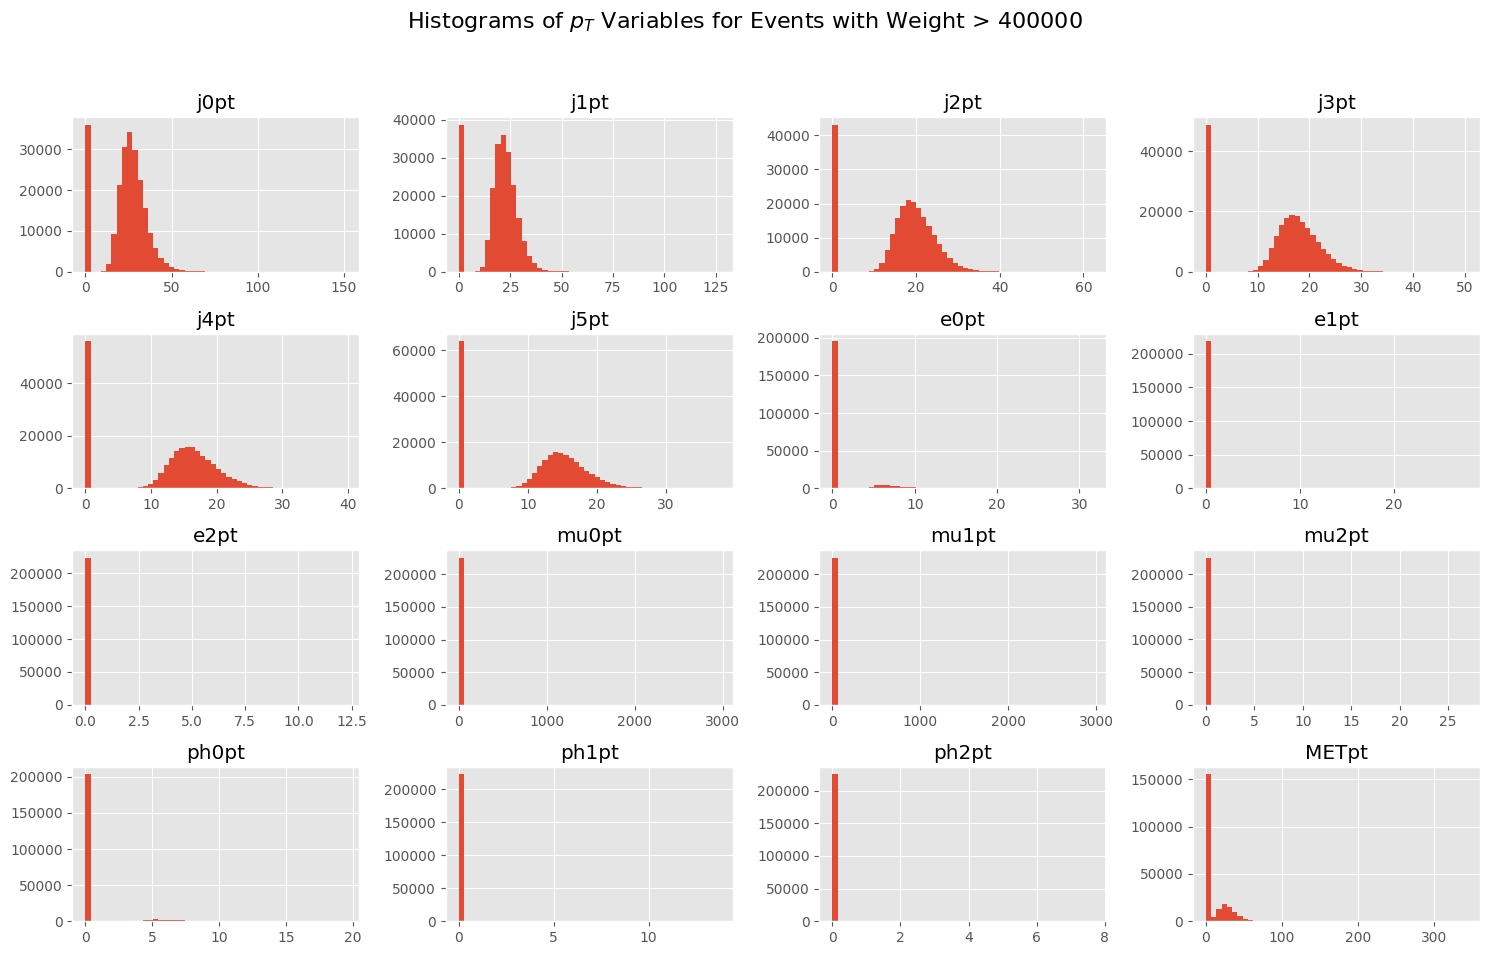

In [27]:
# Filter events with weight > 400000
high_weight_df = combined_hlt_df[combined_hlt_df['weight'] > 400000].copy()

# Print the total number of events with weight > 400000
print(f"Total number of events with weight > 400000: {len(high_weight_df)}")

# Select only the 'pt' columns for plotting
pt_cols_to_plot = [c for c in high_weight_df.columns if 'pt' in c]

# Exclude 'pt' columns where all values are zero in the filtered data
pt_cols_to_plot = [c for c in pt_cols_to_plot if not (high_weight_df[c] == 0).all()]


if not high_weight_df.empty and pt_cols_to_plot:
    # Plot histograms of the selected 'pt' columns
    high_weight_df[pt_cols_to_plot].hist(figsize=(15, 10), bins=50)
    plt.suptitle('Histograms of $p_T$ Variables for Events with Weight > 400000', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
elif high_weight_df.empty:
    print("No events found with weight > 400000.")
else:
    print("No non-zero 'pt' columns found in the filtered data.")

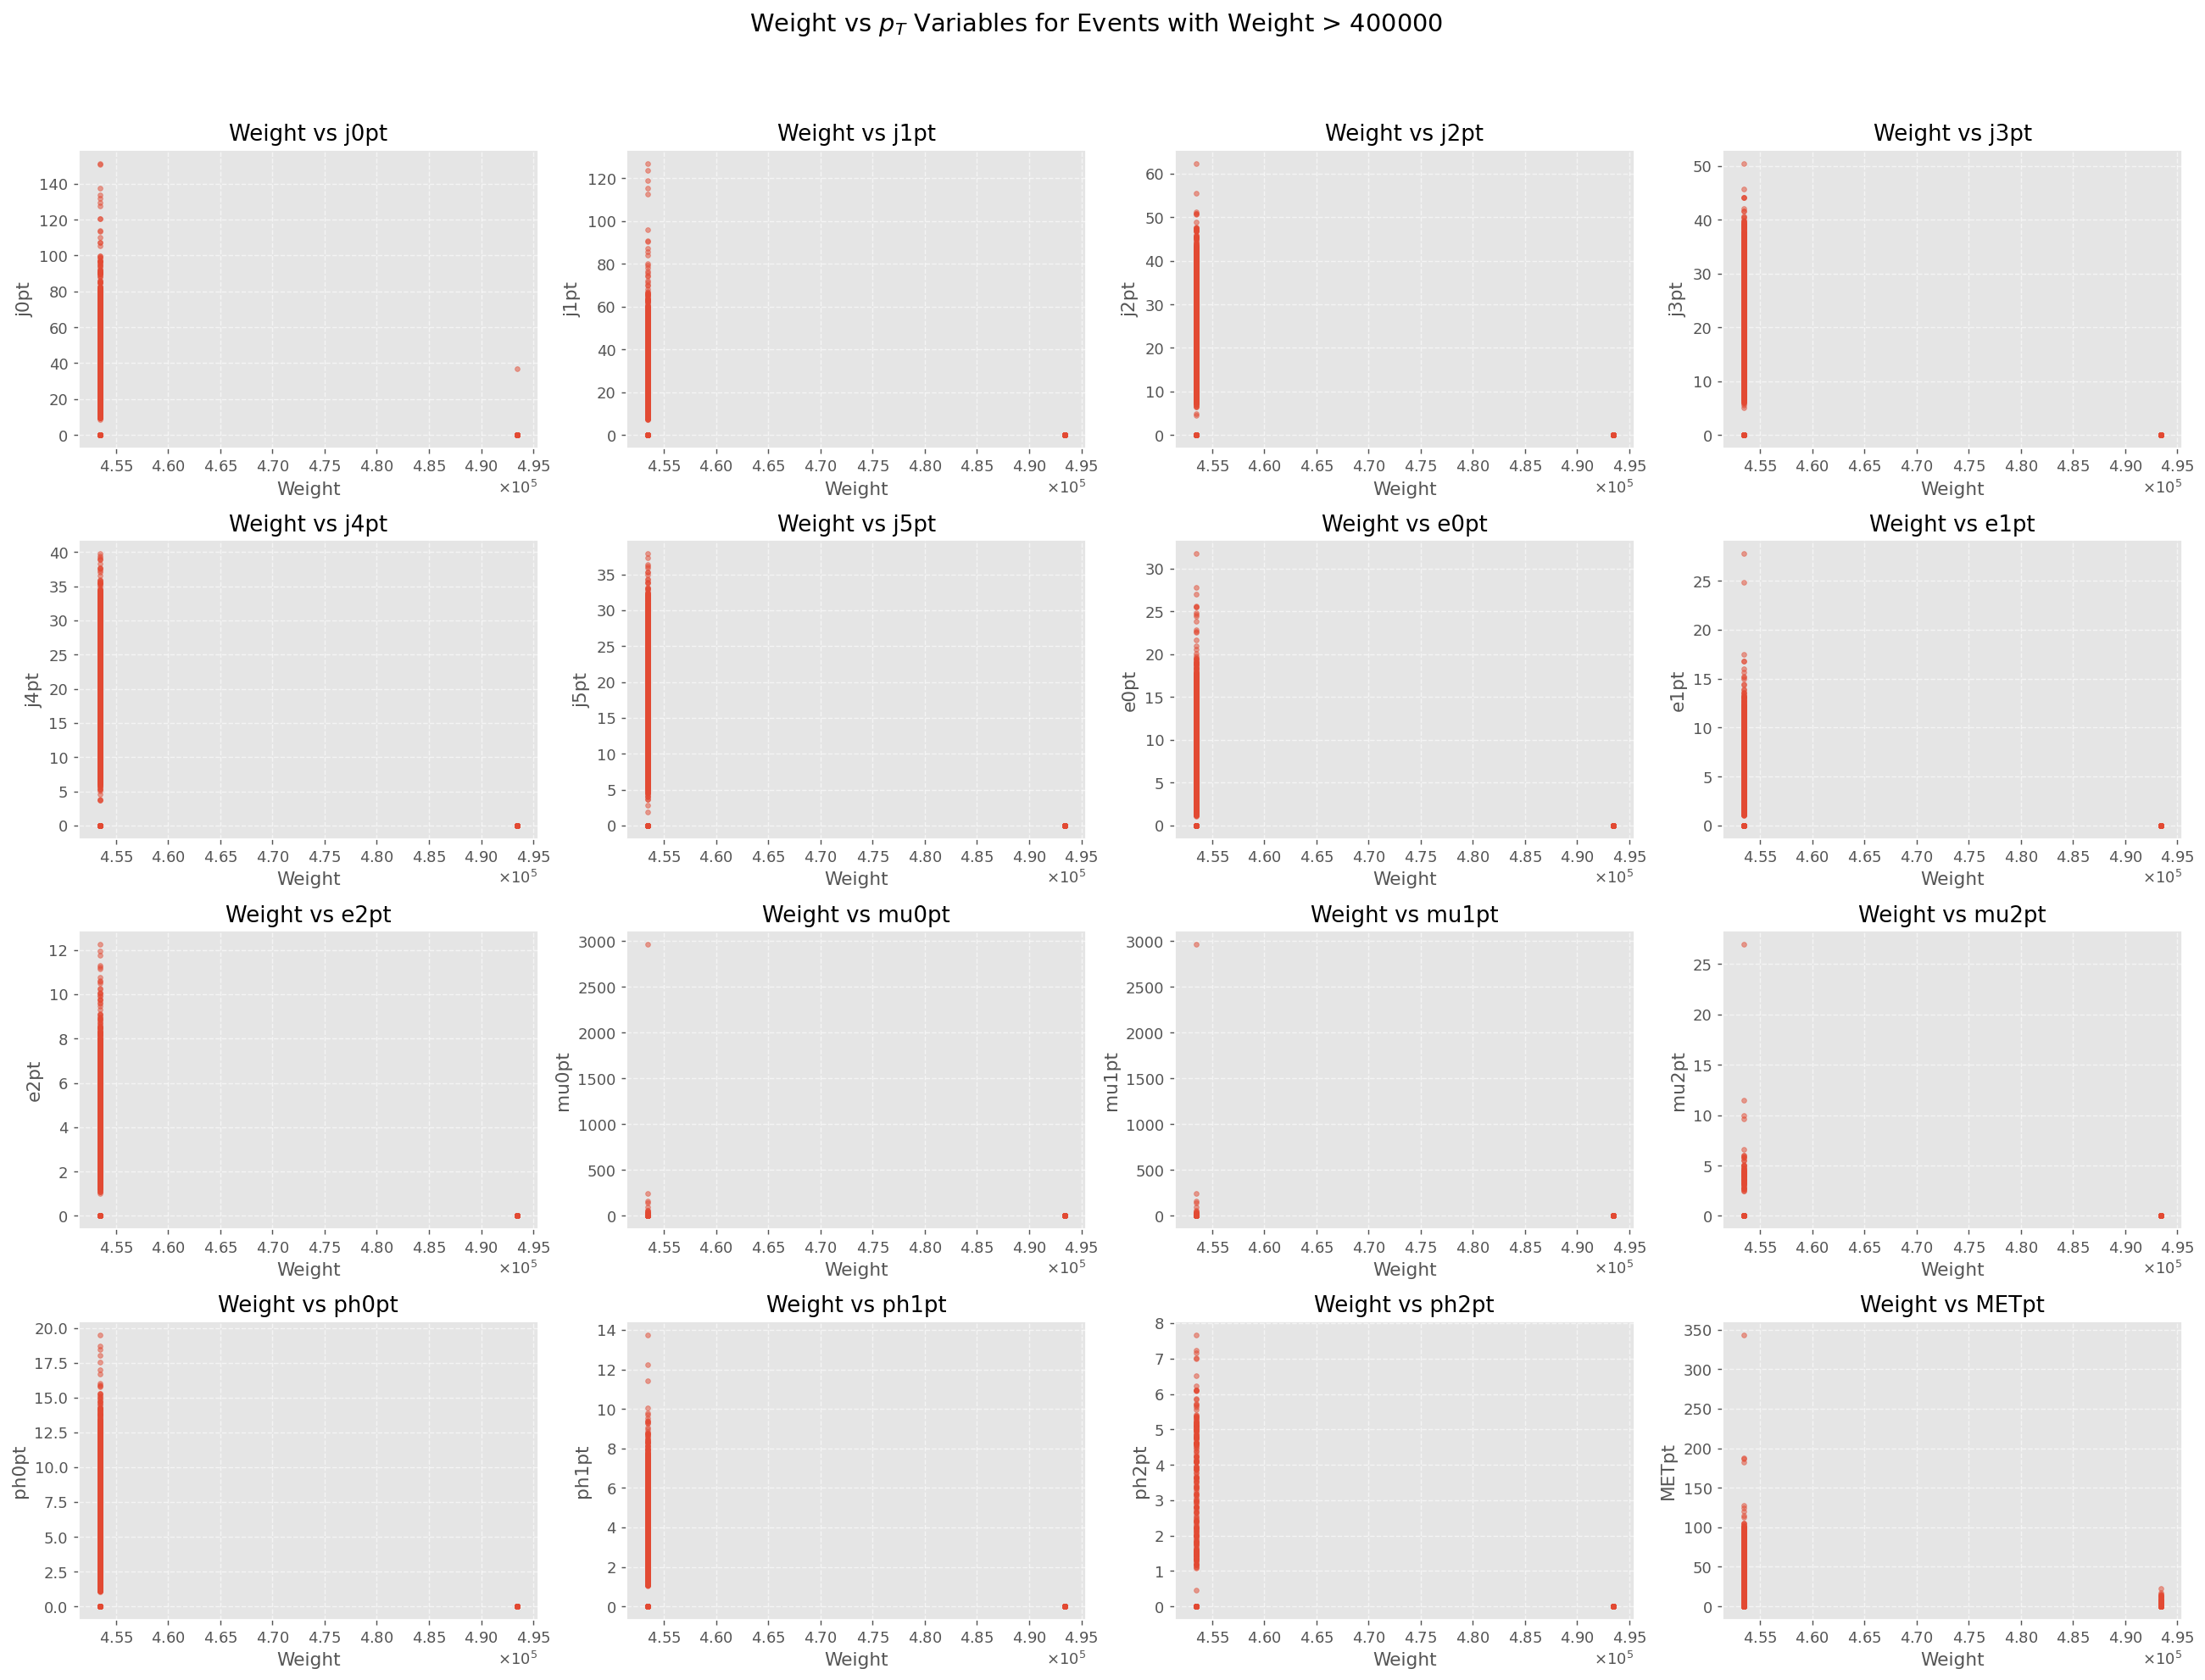

In [28]:
import matplotlib.ticker as mticker

if not high_weight_df.empty and pt_cols_to_plot:
    # Create a relative weight column to make the x-axis readable
    # high_weight_df['weight_rel'] = high_weight_df['weight'] - high_weight_df['weight'].min()

    num_pt_cols = len(pt_cols_to_plot)
    n_cols = 4  # Number of columns in the subplot grid
    n_rows = (num_pt_cols + n_cols - 1) // n_cols  # Number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), dpi=130)
    axes = axes.flatten()  # Flatten for easy iteration

    for i, pt_col in enumerate(pt_cols_to_plot):
        ax = axes[i]

        # Plot using relative weights on x-axis
        ax.scatter(high_weight_df['weight'], high_weight_df[pt_col], s=10, alpha=0.5)

        # Labels and title
        ax.set_xlabel('Weight')
        ax.set_ylabel(pt_col)
        ax.set_title(f'Weight vs {pt_col}')

        # Grid and scientific notation for neatness
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

    # Hide unused subplots
    for j in range(num_pt_cols, len(axes)):
        fig.delaxes(axes[j])

    # Global title and layout
    plt.suptitle(r'Weight vs $p_T$ Variables for Events with Weight > 400000', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the figure
    plt.show()

elif high_weight_df.empty:
    print("No events found with weight > 400000.")
else:
    print("No non-zero 'pt' columns found in the filtered data.")


In [ ]:
'''
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=None,  # disables determinism
    n_jobs=-1           # uses all CPU cores
)

embedding = reducer.fit_transform(filtered_df)

plt.figure(figsize=(8,6),dpi=150)
plt.scatter(embedding[:,0], embedding[:,1], s=5, alpha=0.6)
plt.title(f'UMAP projection (2D) for {target_name}')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
plt.show()
'''

"\nreducer = umap.UMAP(\n    n_neighbors=15,\n    min_dist=0.1,\n    n_components=2,\n    random_state=None,  # disables determinism\n    n_jobs=-1           # uses all CPU cores\n)\n\nembedding = reducer.fit_transform(filtered_df)\n\nplt.figure(figsize=(8,6),dpi=150)\nplt.scatter(embedding[:,0], embedding[:,1], s=5, alpha=0.6)\nplt.title(f'UMAP projection (2D) for {target_name}')\nplt.xlabel('UMAP 1')\nplt.ylabel('UMAP 2')\nplt.tight_layout()\nplt.show()\n"

In [ ]:
'''
# Filter the DataFrame for the specified target and drop the target column
filtered_df = combined_hlt_df[combined_hlt_df['target'] == target_name].drop('target', axis=1)

# --- 3D UMAP embedding ---
reducer_3d = umap.UMAP(
    n_components=3,
    n_neighbors=15,
    min_dist=0.1,
    random_state=None,  # allow multi-threading
    n_jobs=-1           # use all CPU cores
)

embedding_3d = reducer_3d.fit_transform(filtered_df)

# --- Choose the feature to color by ---
# You can change the column index (e.g., to 1, 2, etc.) to color by a different feature
color_feature = filtered_df.iloc[:, 0]
feature_name = filtered_df.columns[3] if isinstance(filtered_df.columns[0], (str, int)) else "Feature 0"

# --- Normalize colors for better visualization ---
norm = plt.Normalize(vmin=np.percentile(color_feature, 1), vmax=np.percentile(color_feature, 99))

# --- Plot 3D UMAP ---
fig = plt.figure(figsize=(9, 7),dpi=150)
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(
    embedding_3d[:, 0],
    embedding_3d[:, 1],
    embedding_3d[:, 2],
    c=color_feature,
    cmap='Spectral',
    s=6,
    alpha=0.8,
    norm=norm
)

ax.set_title(f'3D UMAP Projection for {target_name} colored by {feature_name}', fontsize=12)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')

fig.colorbar(p, ax=ax, label=feature_name)
plt.tight_layout()
plt.show()
'''

'\n# Filter the DataFrame for the specified target and drop the target column\nfiltered_df = combined_hlt_df[combined_hlt_df[\'target\'] == target_name].drop(\'target\', axis=1)\n\n# --- 3D UMAP embedding ---\nreducer_3d = umap.UMAP(\n    n_components=3,\n    n_neighbors=15,\n    min_dist=0.1,\n    random_state=None,  # allow multi-threading\n    n_jobs=-1           # use all CPU cores\n)\n\nembedding_3d = reducer_3d.fit_transform(filtered_df)\n\n# --- Choose the feature to color by ---\n# You can change the column index (e.g., to 1, 2, etc.) to color by a different feature\ncolor_feature = filtered_df.iloc[:, 0]\nfeature_name = filtered_df.columns[3] if isinstance(filtered_df.columns[0], (str, int)) else "Feature 0"\n\n# --- Normalize colors for better visualization ---\nnorm = plt.Normalize(vmin=np.percentile(color_feature, 1), vmax=np.percentile(color_feature, 99))\n\n# --- Plot 3D UMAP ---\nfig = plt.figure(figsize=(9, 7),dpi=150)\nax = fig.add_subplot(111, projection=\'3d\')\n\np 

In [ ]:
'''
# Filter the DataFrame for the specified target and drop the target column
filtered_df = combined_hlt_df[combined_hlt_df['target'] == target_name].drop('target', axis=1)

# --- UMAP embedding computed on the filtered data ---
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=None,  # disables determinism
    n_jobs=-1           # uses all CPU cores
)
embedding = reducer.fit_transform(filtered_df)

num_features = filtered_df.shape[1]
cols = 8                           # number of columns in grid
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows), dpi=150)
axes = axes.flatten()

for i in range(num_features):
    ax = axes[i]
    feature = filtered_df.iloc[:, i]
    feature_name = filtered_df.columns[i] if i < len(filtered_df.columns) else f"Feature {i}"

    vmin, vmax = np.percentile(feature, [1, 99])

    sc = ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=feature,
        cmap='plasma',
        s=3,
        alpha=0.7,
        vmin=vmin, vmax=vmax
    )
    ax.set_title(str(feature_name), fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

    # Optional small colorbar for every few subplots
    if i % 8 == 0:
        plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

# Hide any unused subplots
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f"UMAP Projection for {target_name} Colored by Each Feature", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()'''

'\n# Filter the DataFrame for the specified target and drop the target column\nfiltered_df = combined_hlt_df[combined_hlt_df[\'target\'] == target_name].drop(\'target\', axis=1)\n\n# --- UMAP embedding computed on the filtered data ---\nreducer = umap.UMAP(\n    n_neighbors=15,\n    min_dist=0.1,\n    n_components=2,\n    random_state=None,  # disables determinism\n    n_jobs=-1           # uses all CPU cores\n)\nembedding = reducer.fit_transform(filtered_df)\n\nnum_features = filtered_df.shape[1]\ncols = 8                           # number of columns in grid\nrows = math.ceil(num_features / cols)\n\nfig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows), dpi=150)\naxes = axes.flatten()\n\nfor i in range(num_features):\n    ax = axes[i]\n    feature = filtered_df.iloc[:, i]\n    feature_name = filtered_df.columns[i] if i < len(filtered_df.columns) else f"Feature {i}"\n\n    vmin, vmax = np.percentile(feature, [1, 99])\n\n    sc = ax.scatter(\n        embedding[:, 0],\n     

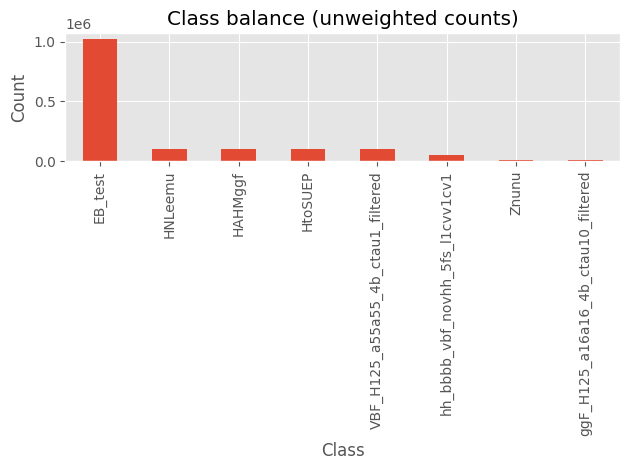

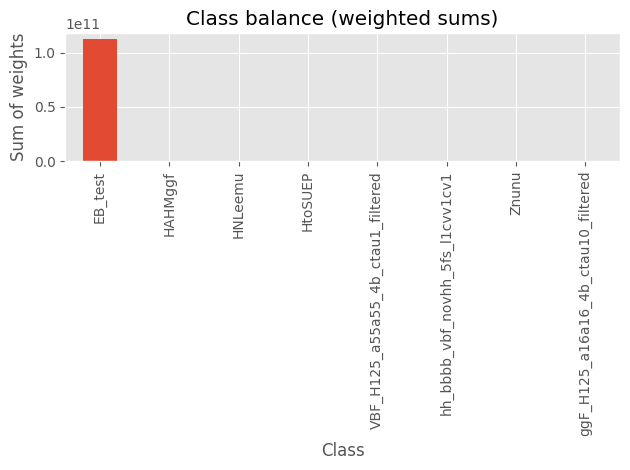

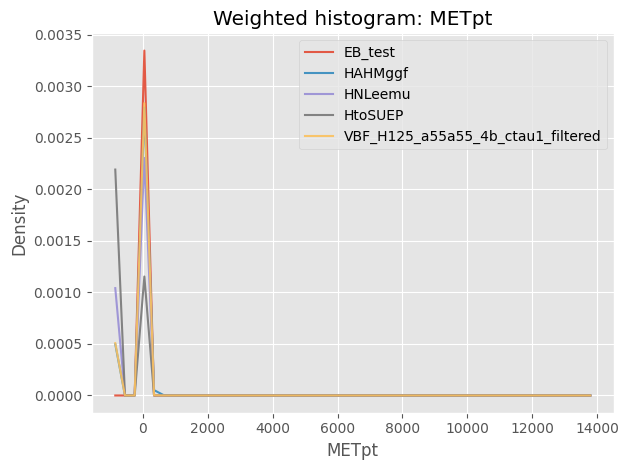

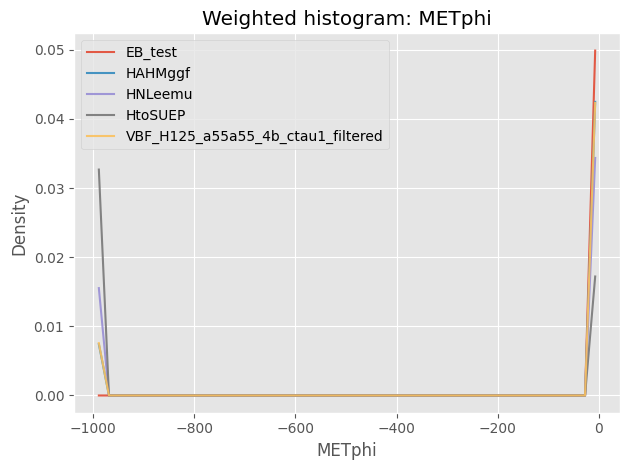

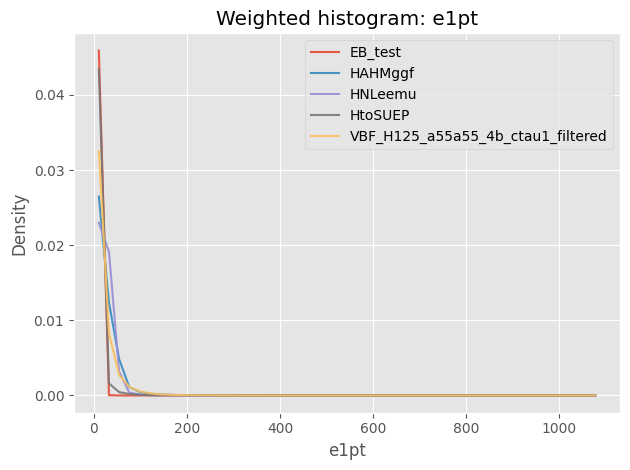

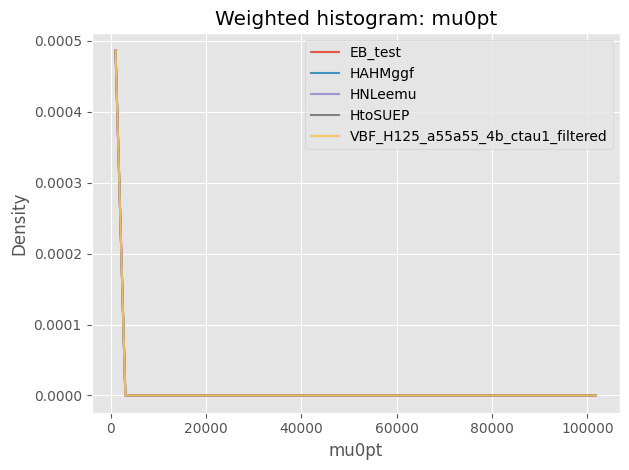

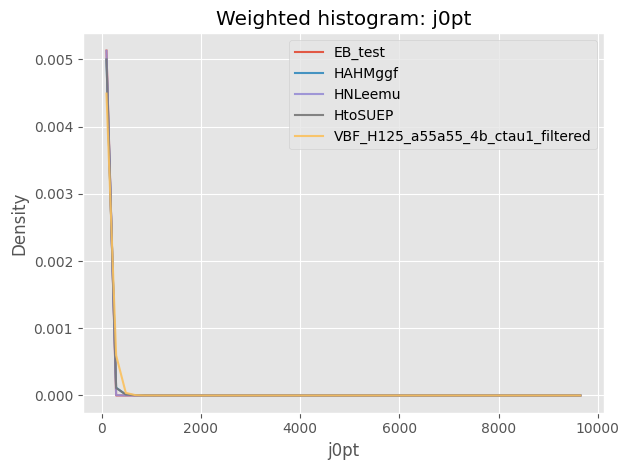

In [ ]:
df = combined_hlt_df.copy()
target_col = 'target'
weight_col = 'weight'

# keep only numeric features (excluding target/weight)
feature_cols = [c for c in df.columns if c not in (target_col, weight_col)]
feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]

# -------- 1) Class balance: unweighted vs weighted --------
# Unweighted
cls_counts = df[target_col].value_counts().sort_values(ascending=False)
plt.figure()
cls_counts.plot(kind='bar')
plt.title('Class balance (unweighted counts)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()

# Weighted
w_counts = df.groupby(target_col)[weight_col].sum().sort_values(ascending=False)
plt.figure()
w_counts.plot(kind='bar')
plt.title('Class balance (weighted sums)')
plt.xlabel('Class')
plt.ylabel('Sum of weights')
plt.tight_layout()

# -------- 2) Weighted histograms by class for a chosen feature --------
def plot_weighted_hist(feature, classes=None, bins=50, density=True):
    x = pd.to_numeric(df[feature], errors='coerce')
    m = x.notna()
    x = x[m]
    w = df.loc[m, weight_col]
    y = df.loc[m, target_col]

    # choose classes to draw (default: top 5 by weighted count)
    if classes is None:
        classes = (df.groupby(target_col)[weight_col]
                     .sum()
                     .sort_values(ascending=False)
                     .head(5).index.tolist())

    # shared bins over full data range
    bin_edges = np.histogram_bin_edges(x.values, bins=bins)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

    plt.figure()
    for c in classes:
        mask = (y == c)
        hist, _ = np.histogram(x[mask], bins=bin_edges,
                               weights=w[mask].values, density=density)
        plt.plot(bin_centers, hist, label=str(c), alpha=0.9)
    plt.title(f'Weighted histogram: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density' if density else 'Weighted count')
    plt.legend()
    plt.tight_layout()

# Plots for some important features (as obtained from Random Forest)
for f in ['METpt','METphi','e1pt','mu0pt','j0pt']:
    plot_weighted_hist(f)



/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


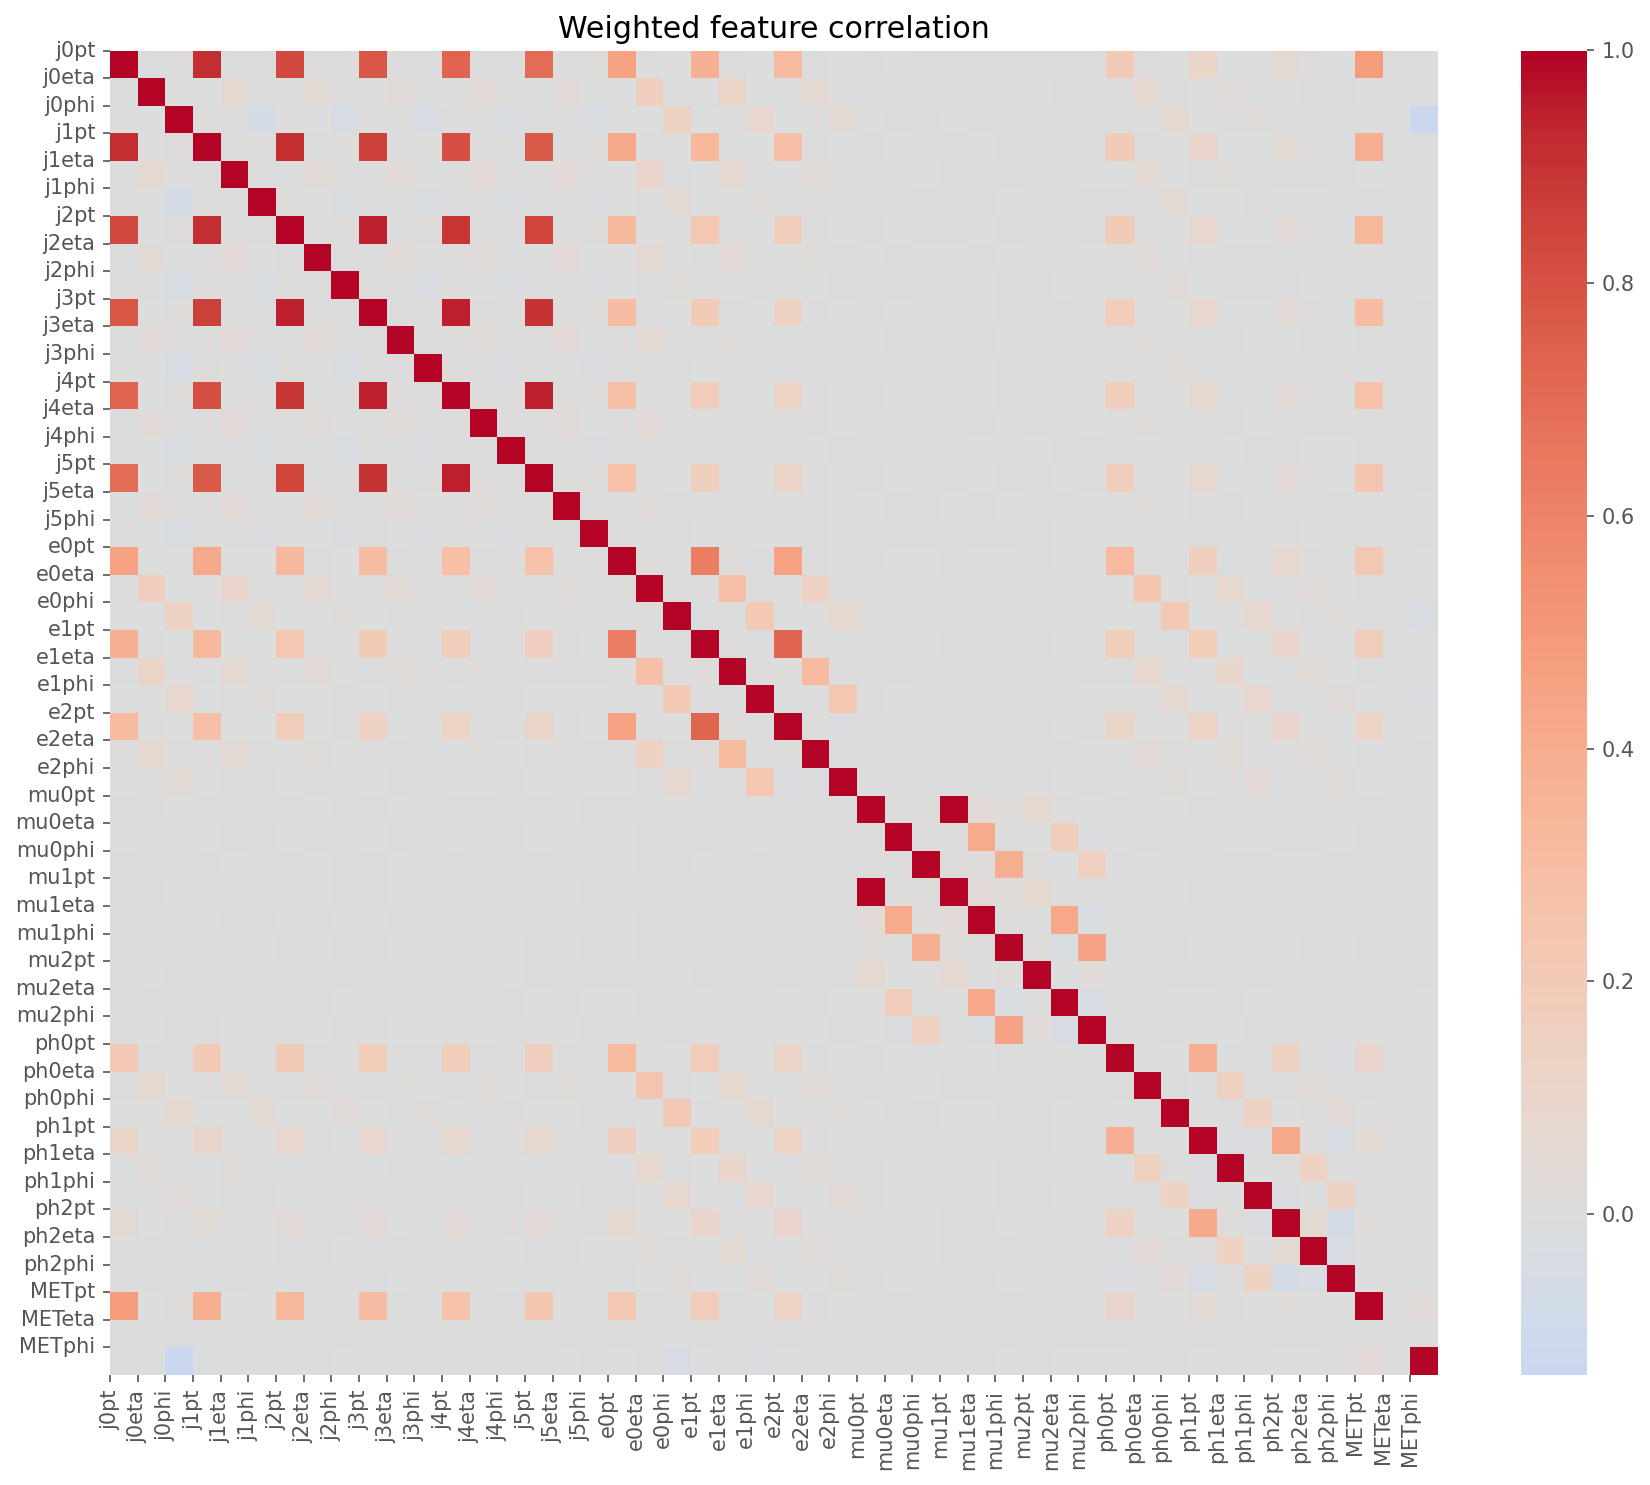

In [ ]:
# -------- 3) Weighted correlation heatmap --------
def weighted_corr(df_num, w):
    # df_num: (N, D) numeric features, w: (N,)
    w = np.asarray(w, dtype=float)
    w = np.where(np.isfinite(w), w, 0.0)
    sw = w.sum()
    X = df_num.values.astype(float)
    # weighted mean
    mu = np.nansum(X * w[:, None], axis=0) / sw
    Xc = X - mu
    # weighted covariance
    cov = (Xc * w[:, None]).T @ Xc / sw
    # std
    sd = np.sqrt(np.diag(cov))
    denom = np.outer(sd, sd)
    with np.errstate(invalid='ignore', divide='ignore'):
        corr = cov / denom
    # clip to [-1,1] and replace NaNs from zero-variance cols
    corr = np.clip(corr, -1, 1)
    corr = np.nan_to_num(corr, nan=0.0)
    return corr

df_num = df[feature_cols].apply(pd.to_numeric, errors='coerce')
corr = weighted_corr(df_num.fillna(0.0), df[weight_col])

plt.figure(figsize=(12,10),dpi=150)
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Weighted feature correlation')
plt.xticks(range(len(feature_cols)), feature_cols, rotation=90)
plt.yticks(range(len(feature_cols)), feature_cols)
plt.tight_layout()

/tmp/ipykernel_37/3421898043.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


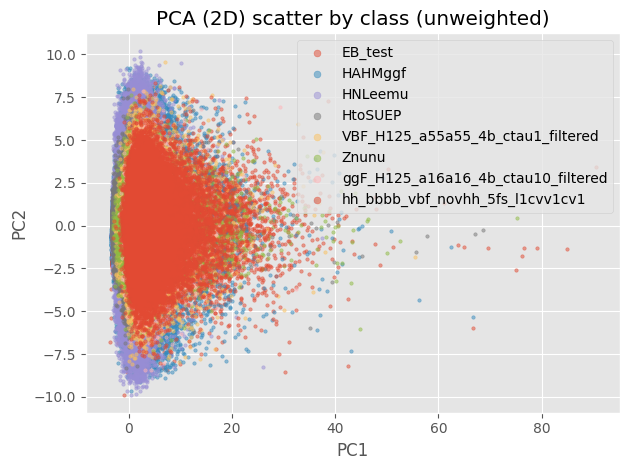

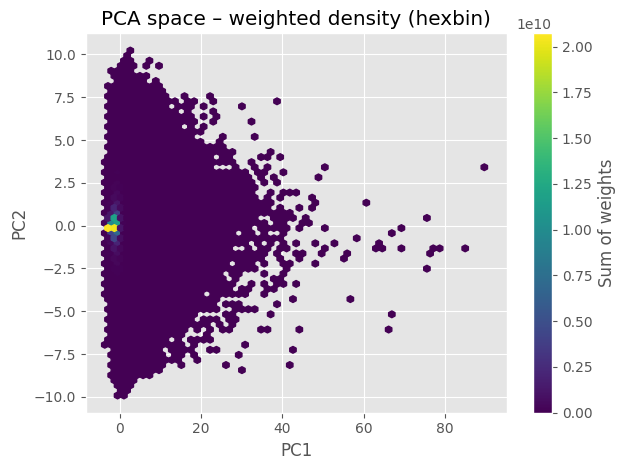

In [ ]:
# -------- 4) PCA scatter (unweighted) + weighted hexbin --------
# Unweighted PCA scatter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df_num.values
# standardize unweighted (simple, robust default)
Xs = (X - np.nanmean(X, axis=0)) / (np.nanstd(X, axis=0) + 1e-12)
Xs = np.nan_to_num(Xs, nan=0.0, posinf=0.0, neginf=0.0)

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(Xs)

plt.figure()
for cls, grp in df.groupby(target_col):
    idx = grp.index
    plt.scatter(Z[idx, 0], Z[idx, 1], s=6, alpha=0.5, label=str(cls))
plt.title('PCA (2D) scatter by class (unweighted)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(markerscale=2)
plt.tight_layout()

# Weighted density view (all classes combined)
plt.figure()
plt.hexbin(Z[:, 0], Z[:, 1],
           C=df[weight_col].values,
           reduce_C_function=np.sum, gridsize=60)
plt.title('PCA space – weighted density (hexbin)')
plt.xlabel('PC1')
plt.ylabel('PC2')
cb = plt.colorbar()
cb.set_label('Sum of weights')
plt.tight_layout()

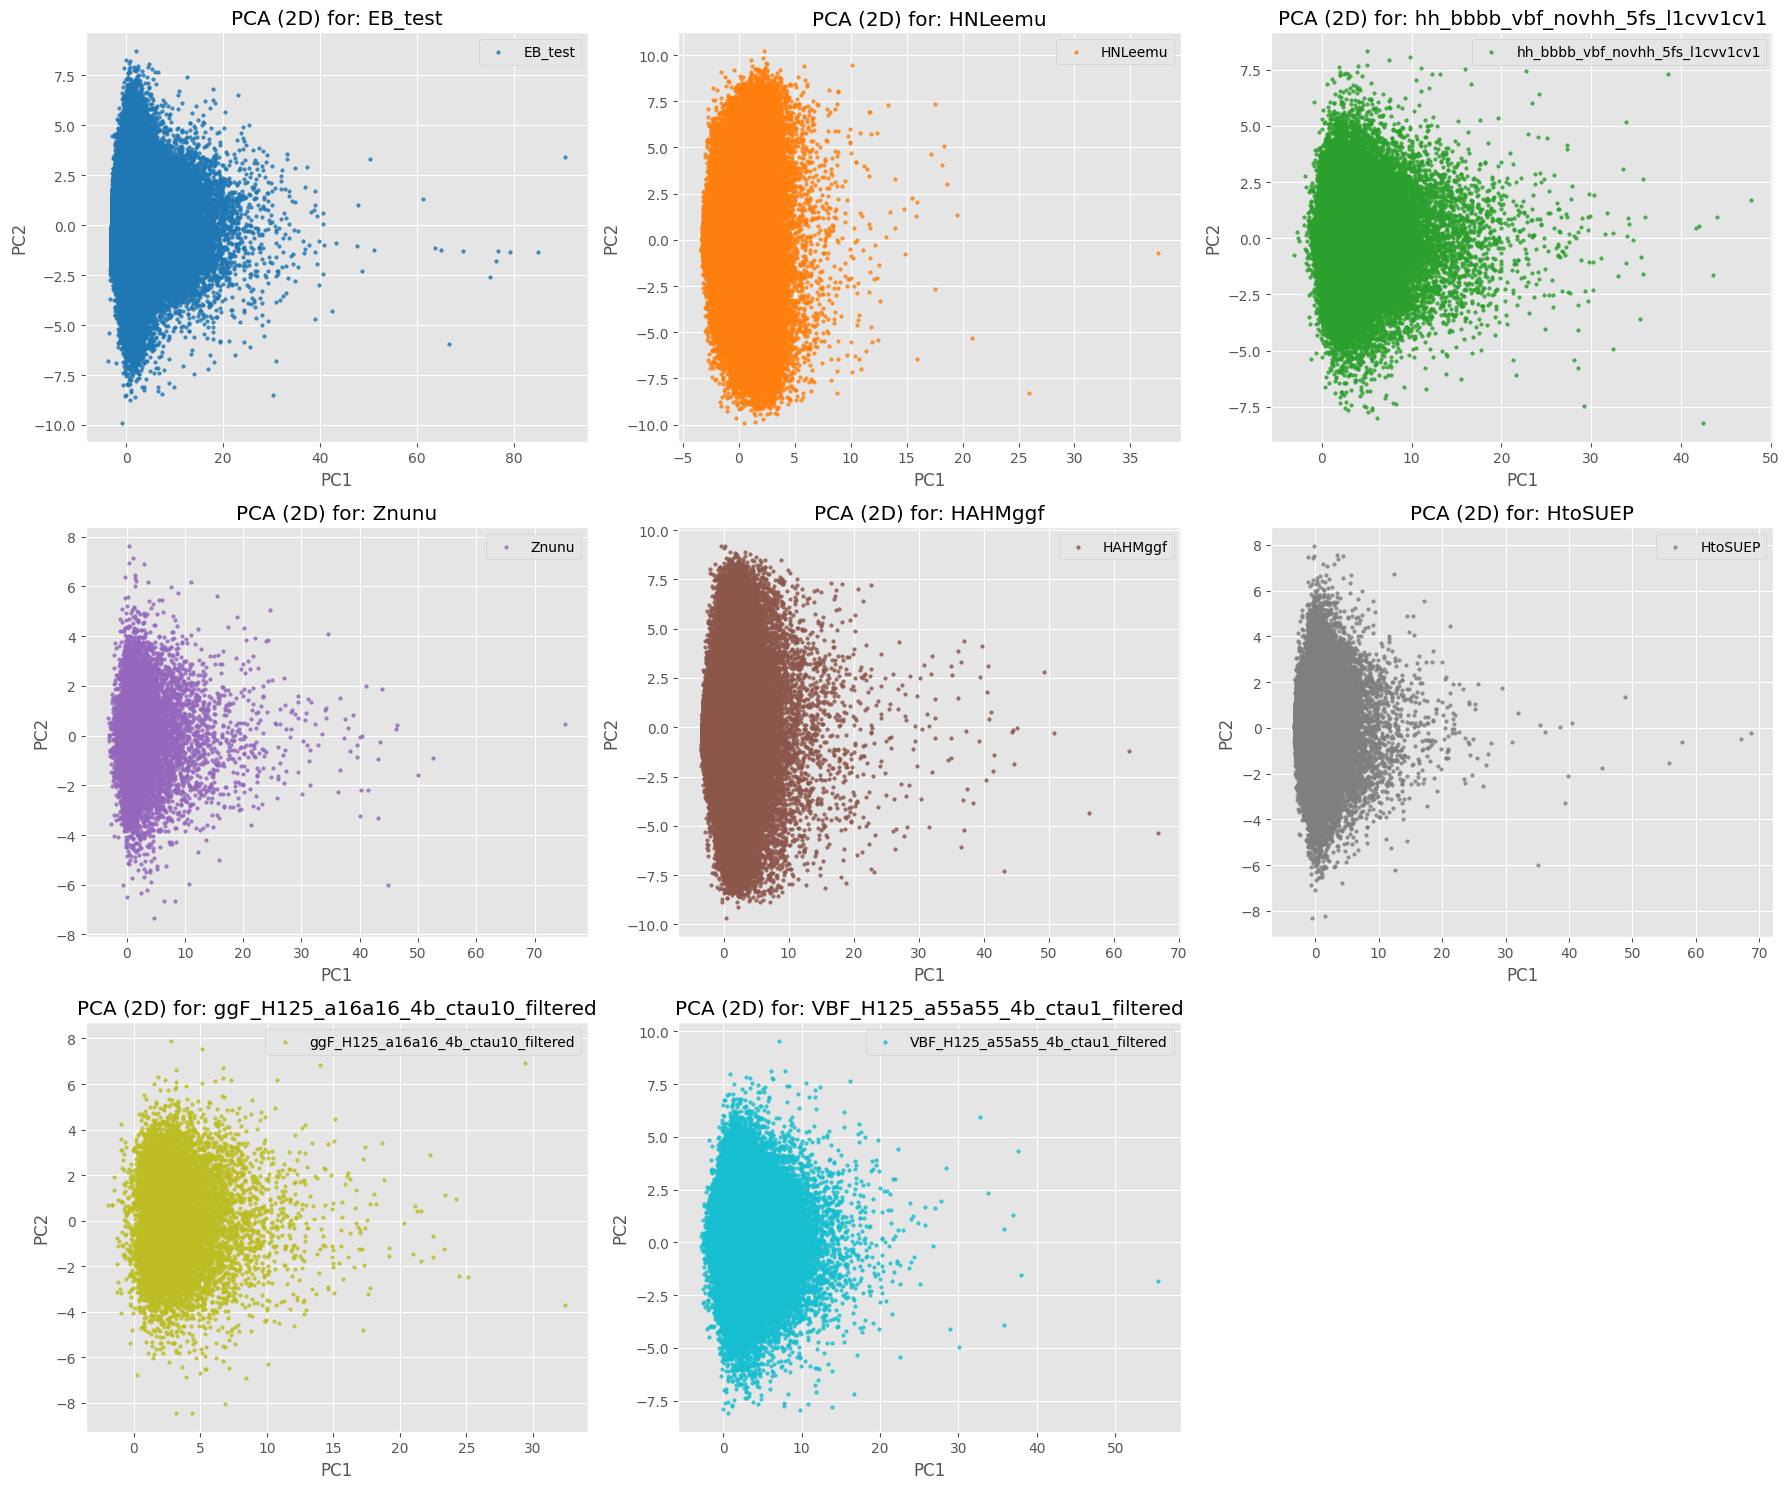

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Keep only numeric features (excluding target/weight)
feature_cols = [c for c in df.columns if c not in ('target', 'weight')]
df_num = df[feature_cols].apply(pd.to_numeric, errors='coerce')
X = df_num.values
# standardize unweighted (simple, robust default)
Xs = (X - np.nanmean(X, axis=0)) / (np.nanstd(X, axis=0) + 1e-12)
Xs = np.nan_to_num(Xs, nan=0.0, posinf=0.0, neginf=0.0)

# Perform PCA
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(Xs)

# Create a figure with subplots for each unique class
unique_classes = df['target'].unique()
n_classes = len(unique_classes)
n_cols = 3  # Number of columns in the subplot grid
n_rows = (n_classes + n_cols - 1) // n_cols  # Calculate number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

colors = plt.cm.tab10(np.linspace(0, 1, n_classes)) # Get distinct colors

for i, cls in enumerate(unique_classes):
    ax = axes[i]
    idx = df[df['target'] == cls].index
    ax.scatter(Z[idx, 0], Z[idx, 1], s=6, alpha=0.8, label=str(cls), color=colors[i])
    ax.set_title(f'PCA (2D) for: {cls}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend()

# Hide any unused subplots
for j in range(n_classes, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In the above PCA plots, the data is standardised.

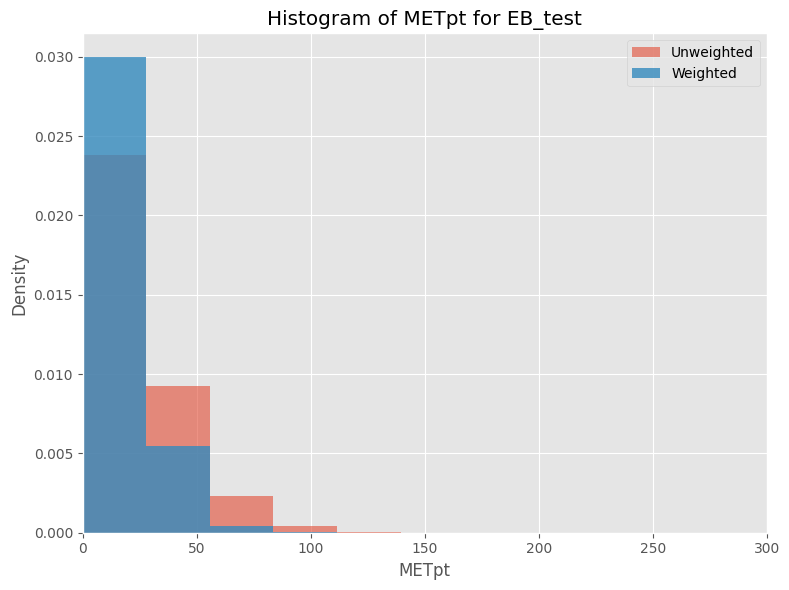

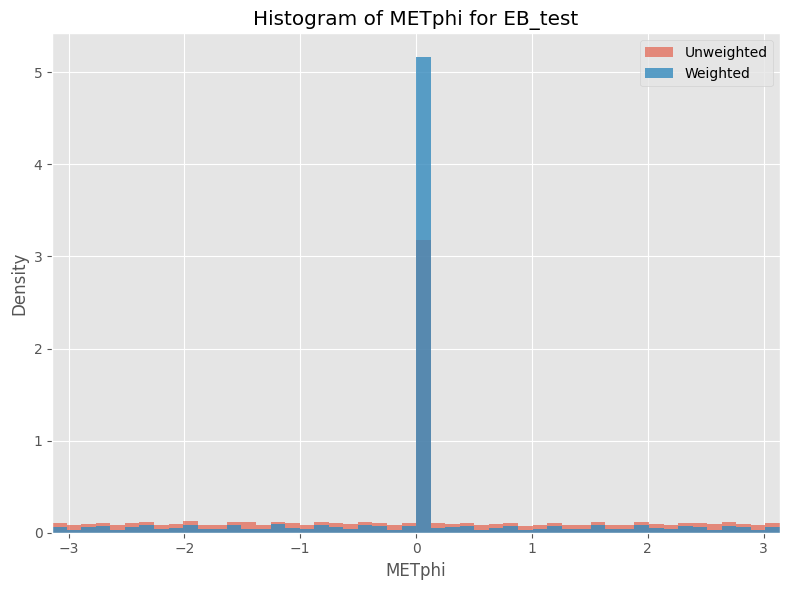

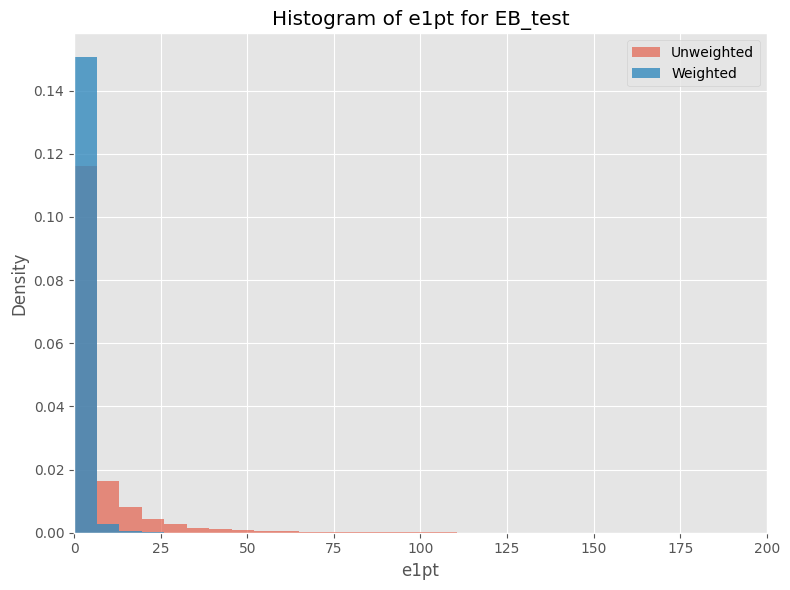

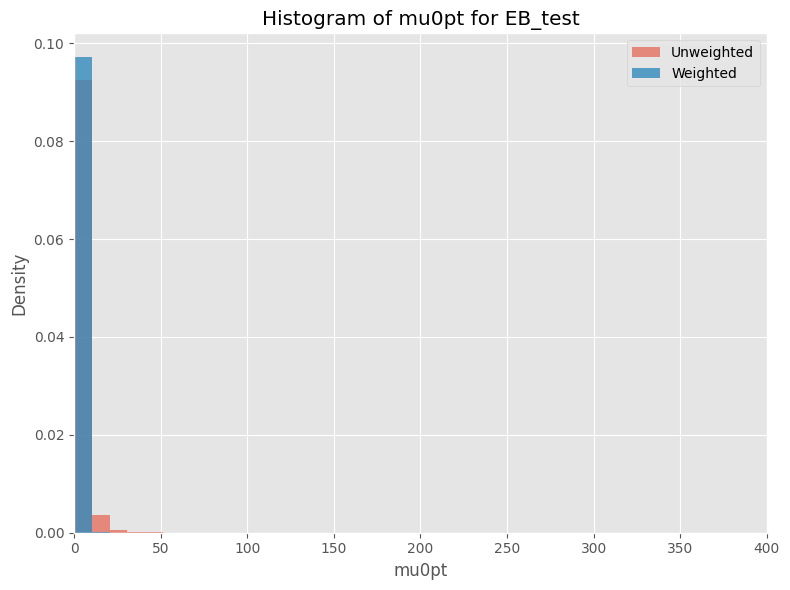

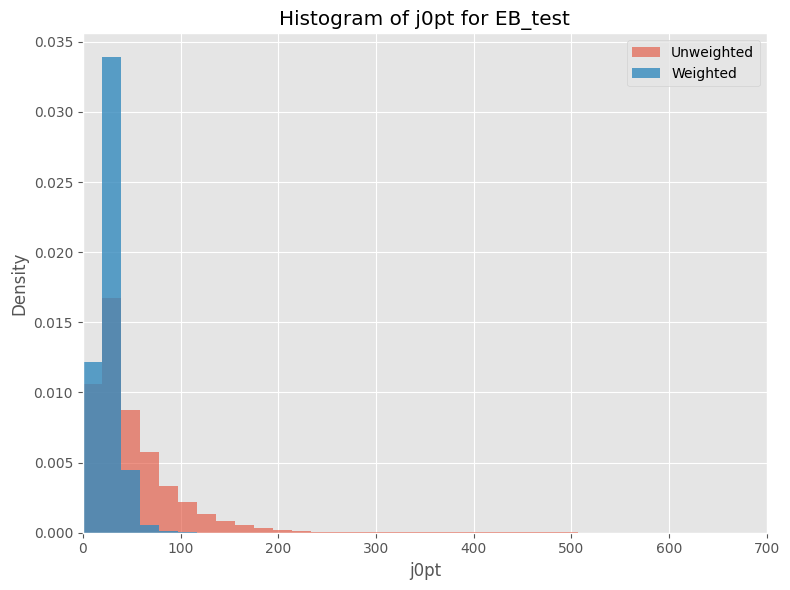

In [ ]:
# Filter for the 'EB_test' class
eb_test_df = df[df['target'] == 'EB_test'].copy()

# Features to plot
features_to_plot = ['METpt','METphi','e1pt','mu0pt','j0pt']

# Define custom xlim for each feature (you can change these values)
feature_xlims = {
    'METpt': (0, 300),
    'METphi': (-np.pi, np.pi),
    'e1pt': (0, 200),
    'mu0pt': (0, 400),
    'j0pt': (0, 700)
}

# Define custom bin counts for each feature (you can change these values)
feature_bins = {
    'METpt': 500,
    'METphi': 50,
    'e1pt': 100,
    'mu0pt': 10000,
    'j0pt': 500
}


# Plot overlaid histograms for each feature
for feature in features_to_plot:
    plt.figure(figsize=(8, 6))

    # Get the number of bins for the current feature, default to 50 if not specified
    bins = feature_bins.get(feature, 50)

    # Unweighted histogram
    plt.hist(eb_test_df[feature].dropna(), bins=bins, alpha=0.6, label='Unweighted', density=True)

    # Weighted histogram
    # Handle potential NaN values and ensure weights are correctly aligned
    feature_values = eb_test_df[feature]
    weights = eb_test_df['weight']
    # Filter out NaNs simultaneously from feature values and weights
    valid_indices = feature_values.dropna().index
    plt.hist(feature_values.loc[valid_indices], bins=bins, alpha=0.8, label='Weighted', density=True, weights=weights.loc[valid_indices])

    plt.title(f'Histogram of {feature} for EB_test')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

    # Apply custom xlim if defined for the feature
    if feature in feature_xlims:
        plt.xlim(feature_xlims[feature])

    plt.tight_layout()
    plt.show()

In [ ]:
# -------- 5) Per-class top features by weighted standardized mean diff --------
def class_feature_smd(df, cls, k=15):
    # weighted standardized mean difference: (mu_cls - mu_rest)/pooled_sd
    X = df_num.values
    w = df[weight_col].values
    is_cls = (df[target_col].values == cls)

    w1 = w * is_cls
    w0 = w * (~is_cls)

    sw1, sw0 = w1.sum(), w0.sum()
    mu1 = np.nansum(X * w1[:, None], axis=0) / max(sw1, 1e-12)
    mu0 = np.nansum(X * w0[:, None], axis=0) / max(sw0, 1e-12)

    # weighted variance for each group
    def wvar(wg, mu):
        xc = X - mu
        return np.nansum((xc * xc) * wg[:, None], axis=0) / max(wg.sum(), 1e-12)

    v1 = wvar(w1, mu1)
    v0 = wvar(w0, mu0)

    pooled_sd = np.sqrt(0.5*(v1 + v0)) + 1e-12
    smd = (mu1 - mu0)/pooled_sd

    out = (pd.DataFrame({'feature': feature_cols,
                         'SMD': smd,
                         'abs_SMD': np.abs(smd)})
             .sort_values('abs_SMD', ascending=False)
             .head(k))
    return out

# Example: top features for a couple of classes
for cls in df[target_col].value_counts().index[:2]:
    topk = class_feature_smd(df, cls, k=15)
    print(f"\nTop features for class={cls} (by |weighted SMD|):")
    print(topk[['feature', 'SMD']].to_string(index=False))



Top features for class=EB_test (by |weighted SMD|):
feature       SMD
   j0pt -1.146229
   j2pt -1.112192
   j3pt -1.093915
   j4pt -1.052121
   e0pt -1.045525
   e1pt -1.029847
   j1pt -1.020210
   j5pt -0.986516
 METphi  0.912064
  METpt  0.806018
   e2pt -0.803853
  ph0pt -0.715217
  ph1pt -0.681730
  ph2pt -0.441514
  mu0pt -0.291605

Top features for class=HNLeemu (by |weighted SMD|):
feature       SMD
   e1pt  1.642124
   e0pt  1.592978
  ph1pt  1.536221
   j0pt  1.528318
  ph0pt  1.521908
   j1pt  1.038837
   e2pt  0.997848
 METphi -0.950843
  METpt -0.891155
   j2pt  0.883297
  ph2pt  0.881579
   j3pt  0.746947
   j4pt  0.664369
   j5pt  0.612041
  mu0pt  0.464273


Short answer: each row’s `weight` is used as a multiplicative sample weight wherever it makes sense.

**1) Class balance (weighted)**

- For each class $c$:
  $$
  \text{weighted_count}(c)=\sum_{i \in c} w_i.
  $$
  (That’s the bar chart labeled “weighted sums”.)

**2) Weighted histograms (per feature, per class)**

- Using `np.histogram(..., weights=...)` with shared bin edges.  
  For class $c$ and bin $k$:
  $$
  \text{count}_{c,k}=\sum_{\substack{i\in c\\ x_i\in \text{bin }k}} w_i.
  $$
- With `density=True`, each class’s histogram is normalized so its area is 1:
  $$
  \text{density}_{c,k}=\frac{\text{count}_{c,k}}{\left(\sum_{i\in c} w_i\right)\,\Delta_k},
  $$
  where $\Delta_k$ is the bin width. Use `density=False` if you want absolute weighted yields instead.

**3) Weighted correlation heatmap**

- Let $X\in\mathbb{R}^{N\times D}$ (features), $w\in\mathbb{R}_{\ge 0}^N$ (weights).
- Weighted mean:
  $$
  \mu_j=\frac{\sum_i w_i X_{ij}}{\sum_i w_i}.
  $$
- Weighted covariance:
  $$
  \mathrm{Cov}_{jk}=\frac{\sum_i w_i \left(X_{ij}-\mu_j\right)\left(X_{ik}-\mu_k\right)}{\sum_i w_i}.
  $$
- Weighted correlation:
  $$
  \rho_{jk}= \frac{\mathrm{Cov}_{jk}}{\sqrt{\mathrm{Cov}_{jj}}\;\sqrt{\mathrm{Cov}_{kk}}}.
  $$
- (We divide by $\sum_i w_i$, not $\sum_i w_i - 1$; i.e., no Bessel correction. We also set NaNs from zero-variance columns to $0$.)

**4) PCA & density**

- The PCA scatter was **unweighted** (simple sanity check).
- The hexbin is **weighted**: each hex shows $\sum_i w_i$ of points falling inside it (using `reduce_C_function=np.sum`, `C=weight`).

**5) “Top features” via weighted SMD (class vs rest)**

- For a class $c$:
  $$
  \mu_1=\frac{\sum_{i\in c} w_i x_i}{\sum_{i\in c} w_i},\qquad
  \mu_0=\frac{\sum_{i\notin c} w_i x_i}{\sum_{i\notin c} w_i}.
  $$
- Weighted variances $v_1, v_0$ computed analogously (replace $x_i$ by $(x_i-\mu)^2$ and sum with the same weights).
- Pooled SD:
  $$
  \sigma=\sqrt{\tfrac{1}{2}(v_1+v_0)}.
  $$
- Standardized mean difference (SMD):
  $$
  \mathrm{SMD}=\frac{\mu_1-\mu_0}{\sigma}.
  $$
  We rank features by $|\mathrm{SMD}|$.

## Model Training



```
My data is in a pandas dataframe, combined_hlt_df. 48 features and 1 target variable called 'target' and 1 column 'weight' containing weights for the respective events (rows).
target
EB_test                               1017586
HAHMggf                                100000
HNLeemu                                100000
HtoSUEP                                100000
VBF_H125_a55a55_4b_ctau1_filtered      100000
hh_bbbb_vbf_novhh_5fs_l1cvv1cv1         50000
Znunu                                   10000
ggF_H125_a16a16_4b_ctau10_filtered      10000
Name: count, dtype: int64
Make all the targets except for EB_test my signals. Do train-test split.
Make a binary classification model. Also give the model evaluation code and hyperparameter tuning.
```



The dataset with all the signals combined and equal amount of signal and background.

In [ ]:
# --- Setup ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report

# ==== 1) Make binary target: signal=1 for everything except EB_test ====
y = (combined_hlt_df['target'] != 'EB_test').astype(int)

# Features: all columns except 'target' and 'weight'
feature_cols = [c for c in combined_hlt_df.columns if c not in ('target', 'weight')]
X = combined_hlt_df[feature_cols]

# If you know all features are numeric, the imputer below is enough.
# If some are categorical, uncomment the line below to one-hot encode them.
# X = pd.get_dummies(X, drop_first=True)

# ==== 2) Balance the classes by downsampling the majority class ====
# Separate majority and minority classes
X_major = X[y == 0]  # Background (EB_test)
y_major = y[y == 0]

X_minor = X[y == 1]  # Signal
y_minor = y[y == 1]

# Downsample majority class
n_minority = len(X_minor)
X_major_downsampled, y_major_downsampled = resample(
    X_major, y_major,
    replace=False,          # sample without replacement
    n_samples=n_minority,   # to match minority class size
    random_state=42
)

# Combine minority class with downsampled majority class
X_balanced = pd.concat([X_major_downsampled, X_minor])
y_balanced = pd.concat([y_major_downsampled, y_minor])

# Shuffle the balanced data
from sklearn.utils import shuffle
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)


# ==== 3) Train/Test split (stratified) on balanced data ====
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)


### Neural Network

#### Prepare data for pytorch

Convert the relevant columns of `combined_hlt_df` into PyTorch tensors, handle missing values, and create a mapping for the multiclass target variable.


In [ ]:
import torch
from sklearn.impute import SimpleImputer

# 1. Select feature columns
feature_cols = [c for c in combined_hlt_df.columns if c not in ('target', 'weight')]
X_np = combined_hlt_df[feature_cols].values

# 2. Create target mapping and convert target to numerical labels
unique_targets = combined_hlt_df['target'].unique()
target_mapping = {target: i for i, target in enumerate(unique_targets)}
y_np = combined_hlt_df['target'].map(target_mapping).values

# 4. Handle missing values in feature NumPy array
imputer = SimpleImputer(strategy='median')
X_imputed_np = imputer.fit_transform(X_np)

# 5. Convert to PyTorch tensors
X_tensor = torch.tensor(X_imputed_np, dtype=torch.float32)
y_tensor = torch.tensor(y_np, dtype=torch.long)

print("Feature tensor shape:", X_tensor.shape)
print("Target tensor shape:", y_tensor.shape)
print("Target mapping:", target_mapping)

Feature tensor shape: torch.Size([1487586, 48])
Target tensor shape: torch.Size([1487586])
Target mapping: {'EB_test': 0, 'HNLeemu': 1, 'hh_bbbb_vbf_novhh_5fs_l1cvv1cv1': 2, 'Znunu': 3, 'HAHMggf': 4, 'HtoSUEP': 5, 'ggF_H125_a16a16_4b_ctau10_filtered': 6, 'VBF_H125_a55a55_4b_ctau1_filtered': 7}


Create a custom PyTorch `Dataset` to handle the data and `DataLoader`s for efficient batching during training and evaluation.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# 2. Define a custom class that inherits from torch.utils.data.Dataset.
class HLTDataset(Dataset):
    # 3. In the __init__ method of the custom dataset class, store the feature tensor (X_tensor) and the target tensor (y_tensor).
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    # 4. Implement the __len__ method to return the total number of samples in the dataset.
    def __len__(self):
        return len(self.features)

    # 5. Implement the __getitem__ method to return a single sample (feature-target pair) given an index.
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# 6. Create an instance of your custom dataset using X_tensor and y_tensor.
full_dataset = HLTDataset(X_tensor, y_tensor)

# 7. Split the dataset into training and testing sets using torch.utils.data.random_split, specifying a test set size (e.g., 20%).
test_size = 0.2
train_size = len(full_dataset) - int(test_size * len(full_dataset))
train_dataset, test_dataset = random_split(full_dataset, [train_size, int(test_size * len(full_dataset))])

# 8. Create DataLoader instances for both the training and testing datasets.
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 9. Print the number of samples in the training and testing sets to verify the split.
print(f"Number of samples in training set: {len(train_dataset)}")
print(f"Number of samples in testing set: {len(test_dataset)}")

Number of samples in training set: 1190069
Number of samples in testing set: 297517


#### Define the neural network architecture

In [ ]:
import torch.nn as nn

# 2. Define a class that inherits from torch.nn.Module.
class DeepNeuralNetwork(nn.Module):
    # 3. In the __init__ method of the class, define the layers.
    def __init__(self, input_features, num_classes):
        super(DeepNeuralNetwork, self).__init__()
        # Define multiple linear layers with ReLU activation
        self.layer_1 = nn.Linear(input_features, 128)
        self.relu_1 = nn.ReLU()
        self.layer_2 = nn.Linear(128, 64)
        self.relu_2 = nn.ReLU()
        self.layer_3 = nn.Linear(64, 32)
        self.relu_3 = nn.ReLU()
        # Output layer
        self.output_layer = nn.Linear(32, num_classes)

    # 4. In the forward method, define the forward pass.
    def forward(self, x):
        x = self.relu_1(self.layer_1(x))
        x = self.relu_2(self.layer_2(x))
        x = self.relu_3(self.layer_3(x))
        x = self.output_layer(x)
        return x

# Get the number of input features from X_tensor
input_features = X_tensor.shape[1]
# Get the number of unique target classes from the target_mapping
num_classes = len(target_mapping)

# Create an instance of the model
model = DeepNeuralNetwork(input_features, num_classes)

print(model)

DeepNeuralNetwork(
  (layer_1): Linear(in_features=48, out_features=128, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (relu_2): ReLU()
  (layer_3): Linear(in_features=64, out_features=32, bias=True)
  (relu_3): ReLU()
  (output_layer): Linear(in_features=32, out_features=8, bias=True)
)


#### Define loss function and optimizer


In [ ]:
import torch.optim as optim

# 2. Choose CrossEntropyLoss as the loss function and instantiate it.
criterion = nn.CrossEntropyLoss()

# 3. Choose Adam as the optimizer and instantiate it, passing the model's parameters and a learning rate (e.g., 0.001).
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function:", criterion)
print("Optimizer:", optimizer)

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


#### Implement training loop

In [ ]:
# 1. Define the number of epochs for training.
num_epochs = 50

# Option to use GPU
use_gpu = True  # Set to False to disable GPU
device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")


# 2. Iterate through the epochs.
for epoch in range(num_epochs):
    # 3. For each epoch, set the model to training mode using model.train().
    model.train()
    running_loss = 0.0

    # 4. Iterate through the train_dataloader to get batches of features and labels.
    for i, (inputs, labels) in enumerate(train_dataloader):
        # Move data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # 5. For each batch:
        # - Perform a forward pass by passing the features through the model to get the outputs.
        outputs = model(inputs)

        # - Calculate the loss using the defined criterion and the model outputs and labels.
        loss = criterion(outputs, labels)

        # - Perform a backward pass by calling loss.backward() to compute gradients.
        loss.backward()

        # - Update the model's weights by calling optimizer.step().
        optimizer.step()

        # - Reset the gradients by calling optimizer.zero_grad().
        optimizer.zero_grad()

        running_loss += loss.item()

        # 6. (Optional) Print the loss at regular intervals (e.g., per batch or per epoch) to monitor training progress.
        # if (i + 1) % 100 == 0: # Print every 100 batches
        #     print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {running_loss/100:.4f}')
        #     running_loss = 0.0

print('Finished Training')

Using device: cuda
Finished Training


#### Implement evaluation loop


In [ ]:
# Pick device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model once
model.to(device)
model.eval()

correct = 0
total = 0

# If your DataLoader was built with pin_memory=True, non_blocking=True helps
with torch.no_grad():
    for batch in test_dataloader:
        # Unpack (handles tuple/list batches)
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            inputs, labels = batch
        else:
            # If your Dataset returns a dict, adapt keys accordingly
            # inputs, labels = batch["inputs"], batch["labels"]
            inputs, labels = batch  # fallback; change if needed

        # Send tensors to the same device as the model
        if isinstance(inputs, dict):
            # For models expecting dicts (e.g., transformers)
            inputs = {k: v.to(device, non_blocking=True) for k, v in inputs.items()}
        else:
            inputs = inputs.to(device, non_blocking=True)

        labels = labels.to(device, non_blocking=True)

        # Ensure dtype is correct for Linear layers/classification
        if torch.is_floating_point(inputs) is False:
            inputs = inputs.float()
        if labels.dtype != torch.long:
            labels = labels.long()

        # Forward + predictions
        outputs = model(inputs)
        # works for logits of shape [B, num_classes]
        predicted = outputs.argmax(dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the model on the {total} test samples: {100 * accuracy:.2f}%')


Accuracy of the model on the 297517 test samples: 87.18%


In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report

# Pick device and move model once
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_labels = []
all_predicted = []

with torch.no_grad():
    for batch in test_dataloader:
        # Unpack batch (adapt if your dataset returns dicts)
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            inputs, labels = batch
        else:
            # e.g., for dict-style datasets:
            # inputs, labels = batch["inputs"], batch["labels"]
            inputs, labels = batch

        # Send to device
        if isinstance(inputs, dict):
            inputs = {k: v.to(device, non_blocking=True) for k, v in inputs.items()}
        else:
            inputs = inputs.to(device, non_blocking=True)
            if not torch.is_floating_point(inputs):
                inputs = inputs.float()

        labels = labels.to(device, non_blocking=True)
        if labels.dtype != torch.long:
            labels = labels.long()

        # Forward & predictions
        outputs = model(inputs)                   # logits [B, num_classes]
        predicted = outputs.argmax(dim=1)         # class indices

        # Collect on CPU for sklearn
        all_labels.append(labels.cpu())
        all_predicted.append(predicted.cpu())

# Concatenate tensors -> numpy
all_labels = torch.cat(all_labels).numpy()
all_predicted = torch.cat(all_predicted).numpy()

# Build target_names aligned to label indices
# If your mapping is {index:int -> name:str}
def build_names_and_labels(target_mapping, present_labels):
    if isinstance(next(iter(target_mapping.keys())), int):
        # id -> name
        labels_order = sorted([i for i in np.unique(present_labels) if i in target_mapping])
        target_names = [target_mapping[i] for i in labels_order]
    else:
        # name -> id
        inv = {v: k for k, v in target_mapping.items()}
        labels_order = sorted([i for i in np.unique(present_labels) if i in inv])
        target_names = [inv[i] for i in labels_order]
    return labels_order, target_names

labels_order, target_names = build_names_and_labels(target_mapping, all_labels)

# Classification report (robust even if some classes are absent in the test set)
report = classification_report(
    all_labels,
    all_predicted,
    labels=labels_order,
    target_names=target_names,
    zero_division=0
)

print("Classification Report:")
print(report)


Classification Report:
                                    precision    recall  f1-score   support

                           EB_test       0.92      0.97      0.94    203403
                           HNLeemu       0.80      0.72      0.76     19762
   hh_bbbb_vbf_novhh_5fs_l1cvv1cv1       0.55      0.48      0.51     10159
                             Znunu       0.80      0.39      0.53      1978
                           HAHMggf       0.83      0.77      0.80     20170
                           HtoSUEP       0.79      0.63      0.70     20011
ggF_H125_a16a16_4b_ctau10_filtered       0.51      0.14      0.22      2049
 VBF_H125_a55a55_4b_ctau1_filtered       0.71      0.72      0.71     19985

                          accuracy                           0.87    297517
                         macro avg       0.74      0.60      0.65    297517
                      weighted avg       0.86      0.87      0.87    297517



### Random Forest Classifier

In [ ]:
# ==== 4) Random Forest (with simple median imputation) ====
rf_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        n_jobs=-1,
        # class_weight="balanced",   # not needed after manual balancing
        max_features="sqrt"
    ))
])

rf_pipe.fit(X_train, y_train)

# Optional quick sanity check:
train_score = rf_pipe.score(X_train, y_train)
test_score  = rf_pipe.score(X_test,  y_test)
print(f"Accuracy — train: {train_score:.3f}, test: {test_score:.3f}")

# ==== 5) Feature importance ====
# Get the trained RF from the pipeline and pair importances with column names
rf = rf_pipe.named_steps["rf"]
# If you used get_dummies above, use X_train.columns after the transform:
feature_names = X_balanced.columns

importances = pd.DataFrame({
    "feature": feature_names,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False).reset_index(drop=True)

# Show top 10
print(importances.head(10))

Accuracy — train: 1.000, test: 0.899
  feature  importance
0   METpt    0.119921
1  METphi    0.110327
2    e1pt    0.064609
3   mu0pt    0.045170
4    j0pt    0.044585
5   ph1pt    0.040797
6   j0eta    0.040568
7    e0pt    0.038395
8    e2pt    0.037944
9    j2pt    0.034960


```
Accuracy — train: 1.000, test: 0.912
feature  importance
0    METpt    0.119026
1   METphi    0.110738
2     e1pt    0.064908
3    mu0pt    0.045508
4     j0pt    0.043558
5    ph1pt    0.041479
6    j0eta    0.040546
7     e0pt    0.039482
8     e2pt    0.037584
9     j2pt    0.034453
10    j1pt    0.034409
11    j3pt    0.031900
12   ph0pt    0.025939
13    j4pt    0.022036
14   j1eta    0.021998
15    j5pt    0.018412
16   j2eta    0.018169
17   ph2pt    0.017769
18   j3eta    0.013690
19   j4eta    0.012166
20   j5eta    0.011774
21   j1phi    0.011661
22   e0eta    0.011541
23   j0phi    0.011532
24   j2phi    0.011480
25   e1eta    0.011426
26   j3phi    0.011379
27   j4phi    0.011361
28   j5phi    0.011288
29   mu1pt    0.011130
30   e1phi    0.010701
31   e0phi    0.009996
32   e2phi    0.008093
33   e2eta    0.007970
34  ph1eta    0.007624
35  ph1phi    0.007301
36  mu0eta    0.007282
37  ph0eta    0.006275
38  ph0phi    0.006026
39  mu0phi    0.005829
40  mu1eta    0.003543
41  ph2eta    0.003481
42  ph2phi    0.003290
43  mu1phi    0.002609
44   mu2pt    0.000700
45  mu2eta    0.000480
46  mu2phi    0.000460
47  METeta    0.000000

```






Now we train and test models for different signal classes separately.

In [ ]:
from collections import OrderedDict

def make_weighted_bg_sets(df,
                          background_label='EB_test',
                          target_col='target',
                          weight_col='weight',
                          reuse_background=True,
                          random_state=42):
    """
    For every signal class (all targets != background_label), create a dataset
    consisting of all rows of that class plus the same number of EB_test rows,
    sampled *without replacement* and *weighted by `weight_col`*.

    Parameters
    ----------
    reuse_background : bool
        If True, EB_test rows may be reused across different signal datasets.
        If False, sampled EB_test rows are disjoint across classes (requires
        enough EB_test rows to cover the total requested sample).
    """
    rng = np.random.default_rng(random_state)

    df = df.copy()

    # Split background and signals
    bg_df = df[df[target_col] == background_label].copy()
    sig_df = df[df[target_col] != background_label].copy()

    # Clean weights (non-negative, finite)
    for d in (bg_df, sig_df):
        w = pd.to_numeric(d[weight_col], errors='coerce').fillna(0.0)
        w[w < 0] = 0.0
        d[weight_col] = w

    # How many background rows needed for each signal class?
    sig_counts = sig_df[target_col].value_counts().to_dict()

    if not reuse_background and sum(sig_counts.values()) > len(bg_df):
        raise ValueError("Not enough EB_test rows to allocate disjoint samples. "
                         "Set reuse_background=True or reduce requested sizes.")

    out = OrderedDict()
    bg_pool = bg_df  # shrinks if reuse_background=False

    for sig_label, n in sig_counts.items():
        # Weighted sample of EB_test
        if reuse_background:
            sampled_bg = bg_df.sample(
                n=n, replace=False,
                weights=bg_df[weight_col],
                random_state=int(rng.integers(1e9))
            )
        else:
            sampled_bg = bg_pool.sample(
                n=n, replace=False,
                weights=bg_pool[weight_col],
                random_state=int(rng.integers(1e9))
            )
            bg_pool = bg_pool.drop(index=sampled_bg.index)

        # All rows of this signal class
        sig_rows = sig_df[sig_df[target_col] == sig_label]

        # Combine and shuffle
        pair = pd.concat([sig_rows, sampled_bg], axis=0)
        pair = pair.sample(frac=1.0, random_state=int(rng.integers(1e9))).reset_index(drop=True)

        out[sig_label] = pair

    return out


In [ ]:
# Build one dataset per signal vs EB_test (weighted sampling)
datasets = make_weighted_bg_sets(combined_hlt_df,
                                 background_label='EB_test',
                                 target_col='target',
                                 weight_col='weight',
                                 reuse_background=True,  # set False for disjoint EB_test across signals
                                 random_state=123)

# Quick sanity check of class balance for each dataset
# for sig, df_pair in datasets.items():
#     print(sig, "counts:\n", df_pair['target'].value_counts(), "\n")


In [ ]:
# Define features (all columns except target and weight)
feature_cols = [c for c in combined_hlt_df.columns if c not in ('target', 'weight')]

# Dictionary to store trained models and evaluation results
models = {}
evaluation_results = {}

# Train a model for each signal dataset
for sig_label, df_pair in datasets.items():
    print(f"Training model for {sig_label} vs EB_test")

    # Define features and target for the current dataset
    X_pair = df_pair[feature_cols]
    y_pair = (df_pair['target'] != 'EB_test').astype(int) # 1 for signal, 0 for background

    # Train/Test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X_pair, y_pair, test_size=0.2, stratify=y_pair, random_state=42
    )

    # Create and train the Random Forest pipeline
    rf_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")), # Handle potential missing values
        ("rf", RandomForestClassifier(
            n_estimators=200, # Reduced for quicker training
            random_state=42,
            n_jobs=-1,
            class_weight="balanced" # Use class weight since we sampled balanced by count, not weighted count
        ))
    ])

    rf_pipe.fit(X_train, y_train)

    # Store the trained model
    models[sig_label] = rf_pipe

    # Evaluate the model
    y_pred = rf_pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    evaluation_results[sig_label] = {
        'accuracy': accuracy,
        'report': report
    }

    print(f"Evaluation for {sig_label}:")
    print(f"Accuracy: {accuracy:.3f}")
    print("Classification Report:")
    print(report)
    print("-" * 30)

Training model for HNLeemu vs EB_test
Evaluation for HNLeemu:
Accuracy: 0.975
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     20000
           1       0.98      0.97      0.97     20000

    accuracy                           0.97     40000
   macro avg       0.97      0.97      0.97     40000
weighted avg       0.97      0.97      0.97     40000

------------------------------
Training model for HtoSUEP vs EB_test
Evaluation for HtoSUEP:
Accuracy: 0.927
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     20000
           1       0.95      0.90      0.93     20000

    accuracy                           0.93     40000
   macro avg       0.93      0.93      0.93     40000
weighted avg       0.93      0.93      0.93     40000

------------------------------
Training model for HAHMggf vs EB_test
Evaluation for HAHMggf:
Accuracy: 0.982
Clas

                               signal  accuracy  precision   recall        f1  \
6  ggF_H125_a16a16_4b_ctau10_filtered  0.999329   0.003503  1.00000  0.006981   
4     hh_bbbb_vbf_novhh_5fs_l1cvv1cv1  0.997773   0.001052  0.99510  0.002101   
3   VBF_H125_a55a55_4b_ctau1_filtered  0.995563   0.000530  0.99330  0.001059   
5                               Znunu  0.991416   0.000267  0.98800  0.000533   
2                             HAHMggf  0.995782   0.000548  0.97505  0.001095   
0                             HNLeemu  0.988479   0.000200  0.97210  0.000400   
1                             HtoSUEP  0.972796   0.000079  0.90550  0.000158   

    roc_auc  avg_precision  
6  0.999994       0.949238  
4  0.999863       0.067483  
3  0.999779       0.327549  
5  0.999542       0.595876  
2  0.998041       0.021574  
0  0.997326       0.771436  
1  0.984113       0.644264  


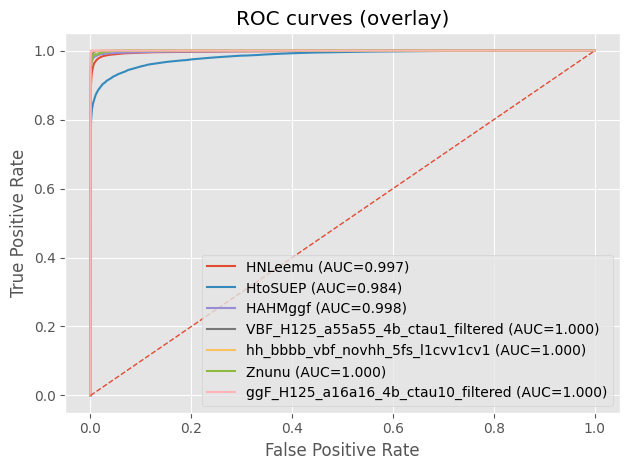

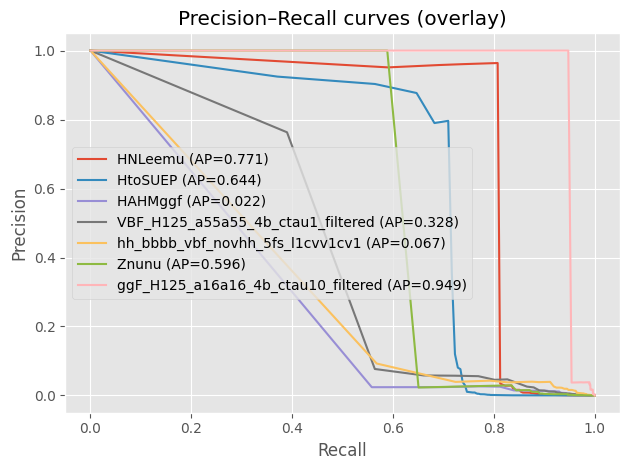

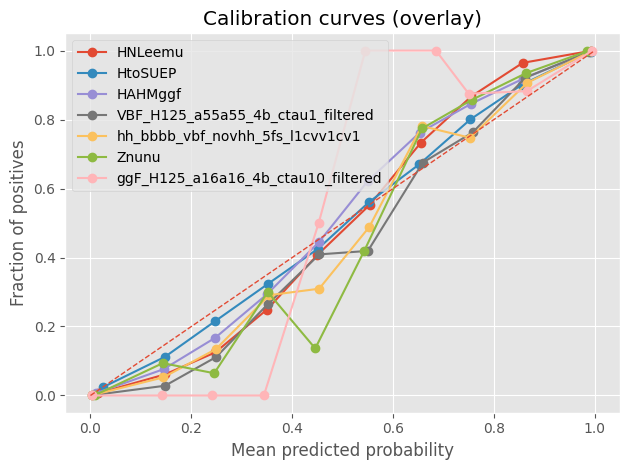

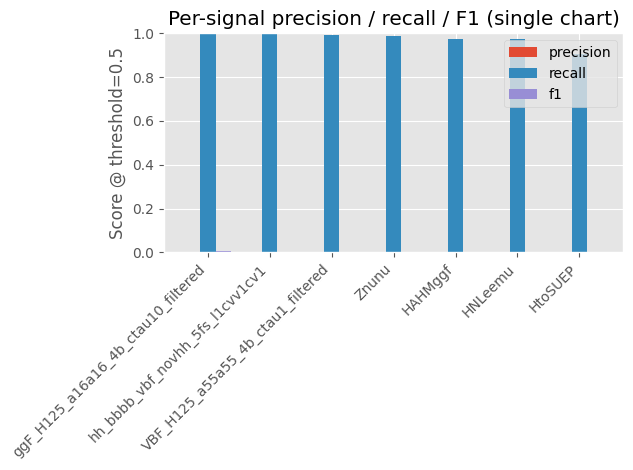

In [ ]:
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score,
    accuracy_score, precision_recall_fscore_support
)
from sklearn.calibration import calibration_curve

# --- Rebuild test splits (same random_state as training) ---
def build_test_splits(datasets, feature_cols, random_state=42):
    splits = {}
    for sig_label, df_pair in datasets.items():
        X = df_pair[feature_cols]
        y = (df_pair['target'] != 'EB_test').astype(int).values
        w = df_pair['weight'].values if 'weight' in df_pair.columns else None

        if w is None:
            Xtr, Xte, ytr, yte = train_test_split(
                X, y, test_size=0.2, stratify=y, random_state=random_state
            )
            wte = None
        else:
            Xtr, Xte, ytr, yte, wtr, wte = train_test_split(
                X, y, w, test_size=0.2, stratify=y, random_state=random_state
            )
        splits[sig_label] = (Xte, yte, wte)
    return splits

test_splits = build_test_splits(datasets, feature_cols, random_state=42)

def get_preds(pipe, X_test):
    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    return y_pred, y_prob

# --- Collect metrics once for all signals ---
rows = []
store_curves = {}  # keep curves ready for plotting without recomputing
for sig_label, pipe in models.items():
    Xte, yte, wte = test_splits[sig_label]
    y_pred, y_prob = get_preds(pipe, Xte)

    # Scalar metrics (at 0.5)
    acc = accuracy_score(yte, y_pred, sample_weight=wte)
    pr, rc, f1, _ = precision_recall_fscore_support(
        yte, y_pred, average='binary', sample_weight=wte, zero_division=0
    )
    rocauc = roc_auc_score(yte, y_prob, sample_weight=wte)
    ap = average_precision_score(yte, y_prob, sample_weight=wte)
    rows.append(dict(signal=sig_label, accuracy=acc, precision=pr, recall=rc, f1=f1, roc_auc=rocauc, avg_precision=ap))

    # Curves (for single overlay plots)
    fpr, tpr, _ = roc_curve(yte, y_prob, sample_weight=wte)
    prec, rec, _ = precision_recall_curve(yte, y_prob, sample_weight=wte)
    frac_pos, mean_pred = calibration_curve(yte, y_prob, n_bins=10, strategy='uniform')
    store_curves[sig_label] = dict(fpr=fpr, tpr=tpr, prec=prec, rec=rec, frac_pos=frac_pos, mean_pred=mean_pred, rocauc=rocauc, ap=ap)

summary = pd.DataFrame(rows).sort_values('roc_auc', ascending=False)
print(summary)

# --- ONE ROC overlay (all signals) ---
plt.figure()
for sig_label, curv in store_curves.items():
    plt.plot(curv['fpr'], curv['tpr'], label=f"{sig_label} (AUC={curv['rocauc']:.3f})")
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (overlay)")
plt.legend()
plt.tight_layout()
plt.show()

# --- ONE Precision–Recall overlay (all signals) ---
plt.figure()
for sig_label, curv in store_curves.items():
    plt.plot(curv['rec'], curv['prec'], label=f"{sig_label} (AP={curv['ap']:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves (overlay)")
plt.legend()
plt.tight_layout()
plt.show()

# --- ONE Calibration (reliability) overlay (all signals) ---
plt.figure()
for sig_label, curv in store_curves.items():
    plt.plot(curv['mean_pred'], curv['frac_pos'], marker='o', label=sig_label)
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves (overlay)")
plt.legend()
plt.tight_layout()
plt.show()

# --- ONE grouped bar chart: compare precision / recall / F1 across signals ---
metrics_to_show = ['precision', 'recall', 'f1']
x = np.arange(len(summary['signal']))
width = 0.25

plt.figure()
for i, m in enumerate(metrics_to_show):
    plt.bar(x + i*width - width, summary[m].values, width, label=m)
plt.xticks(x, summary['signal'], rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel("Score @ threshold=0.5")
plt.title("Per-signal precision / recall / F1 (single chart)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Optional: single bars for AUC and AP (quality at a glance) ---
# plt.figure()
# plt.bar(summary['signal'], summary['roc_auc'])
# plt.xticks(rotation=45, ha='right')
# plt.ylabel("ROC AUC")
# plt.title("Model quality by signal (AUC)")
# plt.tight_layout()
# plt.show()

# plt.figure()
# plt.bar(summary['signal'], summary['avg_precision'])
# plt.xticks(rotation=45, ha='right')
# plt.ylabel("Average Precision")
# plt.title("Model quality by signal (AP)")
# plt.tight_layout()
# plt.show()
